# records

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from numba import njit
from collections import namedtuple
from datetime import datetime

In [3]:
# Disable caching for performance testing
# NOTE: Expect waterfall of executions, since some attributes depend on other attributes 
# that have to be calculated again and again
vbt.settings.caching['enabled'] = False

In [4]:
example_dt = np.dtype([
    ('id', np.int64),
    ('idx', np.int64),
    ('col', np.int64),
    ('some_field1', np.float64),
    ('some_field2', np.float64)
], align=True)

In [5]:
records_arr = np.asarray([
    (0, 0, 0, 10, 21),
    (1, 1, 0, 11, 20),
    (2, 2, 0, 12, 19),
    (3, 0, 1, 13, 18),
    (4, 1, 1, 14, 17),
    (5, 2, 1, 13, 18),
    (6, 0, 2, 12, 19),
    (7, 1, 2, 11, 20),
    (8, 2, 2, 10, 21)
], dtype=example_dt)
print(records_arr)
print(records_arr.shape)

columns = pd.MultiIndex.from_arrays([[0, 1, 1, 1], ['a', 'b', 'c', 'd']], names=['lvl1', 'lvl2'])
wrapper = vbt.ArrayWrapper(index=['x', 'y', 'z'], columns=columns, ndim=2, freq='1 days')
records = vbt.Records(wrapper, records_arr)

records_grouped = vbt.Records(wrapper.copy(group_by=0), records_arr)

[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.) (5, 2, 1, 13., 18.)
 (6, 0, 2, 12., 19.) (7, 1, 2, 11., 20.) (8, 2, 2, 10., 21.)]
(9,)


In [6]:
big_records_arr = np.asarray(list(zip(*(
    np.arange(1000000),
    np.tile(np.arange(1000), 1000),
    np.repeat(np.arange(1000), 1000),
    np.random.randint(0, 100, size=1000000),
    np.random.randint(0, 100, size=1000000)))), dtype=example_dt)
print(big_records_arr.shape)

big_columns = pd.MultiIndex.from_arrays([np.repeat(np.array([0, 1]), 500), np.arange(1000)], names=['lvl1', 'lvl2'])
big_wrapper = vbt.ArrayWrapper(index=np.arange(1000), columns=big_columns, ndim=2, freq='1 days')
big_records = vbt.Records(big_wrapper, big_records_arr)

big_records_grouped = vbt.Records(big_wrapper.copy(group_by=0), big_records_arr)

(1000000,)


In [7]:
records_nosort = records.copy(records_arr=records.records_arr[::-1])
print(records_nosort.records_arr)

big_records_nosort = big_records.copy(records_arr=big_records.records_arr[::-1])

[(8, 2, 2, 10., 21.) (7, 1, 2, 11., 20.) (6, 0, 2, 12., 19.)
 (5, 2, 1, 13., 18.) (4, 1, 1, 14., 17.) (3, 0, 1, 13., 18.)
 (2, 2, 0, 12., 19.) (1, 1, 0, 11., 20.) (0, 0, 0, 10., 21.)]


In [10]:
group_by = pd.Series(['first', 'first', 'second', 'second'], name='group')
big_group_by = pd.Series(np.repeat(np.array([0, 1]), 500))

## ColumnMapper

In [9]:
print(records.col_mapper.col_arr)

[0 0 0 1 1 1 2 2 2]


In [10]:
print(records.col_mapper.get_col_arr())
print(records_grouped.col_mapper.get_col_arr())

%timeit big_records_grouped.col_mapper.get_col_arr()

[0 0 0 1 1 1 2 2 2]
[0 0 0 1 1 1 1 1 1]
7.47 µs ± 70.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
print(records.col_mapper.col_range)

%timeit big_records.col_mapper.col_range

[[ 0  3]
 [ 3  6]
 [ 6  9]
 [-1 -1]]
6.99 µs ± 73.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [12]:
print(records.col_mapper.get_col_range())
print(records_grouped.col_mapper.get_col_range())

%timeit big_records_grouped.col_mapper.get_col_range()

[[ 0  3]
 [ 3  6]
 [ 6  9]
 [-1 -1]]
[[0 3]
 [3 9]]
7.38 µs ± 56.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [13]:
print(records.col_mapper.col_map)

%timeit big_records.col_mapper.col_map

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([3, 3, 3, 0]))
7.03 µs ± 22.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [14]:
print(records.col_mapper.get_col_map())
print(records_grouped.col_mapper.get_col_map())

%timeit big_records_grouped.col_mapper.get_col_map()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([3, 3, 3, 0]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([3, 6]))
7.43 µs ± 46.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [15]:
print(records.col_mapper.is_sorted())
%timeit big_records.col_mapper.is_sorted()

print(records_nosort.col_mapper.is_sorted())
%timeit big_records_nosort.col_mapper.is_sorted()

True
7.48 µs ± 48.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
False
7.49 µs ± 8.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## MappedArray

In [9]:
mapped_array = records.map_field('some_field1')
big_mapped_array = big_records.map_field('some_field1')

mapped_array_nosort = records_nosort.map_field('some_field1')
big_mapped_array_nosort = big_records_nosort.map_field('some_field1')

mapped_array_grouped = records_grouped.map_field('some_field1')
big_mapped_array_grouped = big_records_grouped.map_field('some_field1')

In [17]:
print(mapped_array[(0, 'a')].values)
print(mapped_array[(0, 'a')].col_arr)
print(mapped_array[(0, 'a')].wrapper.columns)

print(mapped_array[(1, 'b')].values)
print(mapped_array[(1, 'b')].col_arr)
print(mapped_array[(1, 'b')].wrapper.columns)

print(mapped_array[[(0, 'a'), (0, 'a')]].values)
print(mapped_array[[(0, 'a'), (0, 'a')]].col_arr)
print(mapped_array[[(0, 'a'), (0, 'a')]].wrapper.columns)

print(mapped_array[[(0, 'a'), (1, 'b')]].values)
print(mapped_array[[(0, 'a'), (1, 'b')]].col_arr)
print(mapped_array[[(0, 'a'), (1, 'b')]].wrapper.columns)

%timeit big_mapped_array.iloc[0]
%timeit big_mapped_array.iloc[:]

[10. 11. 12.]
[0 0 0]
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
[13. 14. 13.]
[0 0 0]
MultiIndex([(1, 'b')],
           names=['lvl1', 'lvl2'])
[10. 11. 12. 10. 11. 12.]
[0 0 0 1 1 1]
MultiIndex([(0, 'a'),
            (0, 'a')],
           names=['lvl1', 'lvl2'])
[10. 11. 12. 13. 14. 13.]
[0 0 0 1 1 1]
MultiIndex([(0, 'a'),
            (1, 'b')],
           names=['lvl1', 'lvl2'])
916 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
13.5 ms ± 340 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
print(mapped_array_nosort[(0, 'a')].values)
print(mapped_array_nosort[(0, 'a')].col_arr)
print(mapped_array_nosort[(0, 'a')].wrapper.columns)

print(mapped_array_nosort[(1, 'b')].values)
print(mapped_array_nosort[(1, 'b')].col_arr)
print(mapped_array_nosort[(1, 'b')].wrapper.columns)

print(mapped_array_nosort[[(0, 'a'), (0, 'a')]].values)
print(mapped_array_nosort[[(0, 'a'), (0, 'a')]].col_arr)
print(mapped_array_nosort[[(0, 'a'), (0, 'a')]].wrapper.columns)

print(mapped_array_nosort[[(0, 'a'), (1, 'b')]].values)
print(mapped_array_nosort[[(0, 'a'), (1, 'b')]].col_arr)
print(mapped_array_nosort[[(0, 'a'), (1, 'b')]].wrapper.columns)

%timeit big_mapped_array_nosort.iloc[0]
%timeit big_mapped_array_nosort.iloc[:]

[12. 11. 10.]
[0 0 0]
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
[13. 14. 13.]
[0 0 0]
MultiIndex([(1, 'b')],
           names=['lvl1', 'lvl2'])
[12. 11. 10. 12. 11. 10.]
[0 0 0 1 1 1]
MultiIndex([(0, 'a'),
            (0, 'a')],
           names=['lvl1', 'lvl2'])
[12. 11. 10. 13. 14. 13.]
[0 0 0 1 1 1]
MultiIndex([(0, 'a'),
            (1, 'b')],
           names=['lvl1', 'lvl2'])
897 µs ± 5.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
14.2 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
print(mapped_array_grouped[0].wrapper.columns)  # indexing on groups, not columns!
print(mapped_array_grouped[0].wrapper.ndim)
print(mapped_array_grouped[0].wrapper.grouped_ndim)
print(mapped_array_grouped[0].wrapper.grouper.group_by)

print(mapped_array_grouped[1].wrapper.columns)
print(mapped_array_grouped[1].wrapper.ndim)
print(mapped_array_grouped[1].wrapper.grouped_ndim)
print(mapped_array_grouped[1].wrapper.grouper.group_by)

print(mapped_array_grouped[[0]].wrapper.columns)
print(mapped_array_grouped[[0]].wrapper.ndim)
print(mapped_array_grouped[[0]].wrapper.grouped_ndim)
print(mapped_array_grouped[[0]].wrapper.grouper.group_by)

print(mapped_array_grouped[[0, 1]].wrapper.columns)
print(mapped_array_grouped[[0, 1]].wrapper.ndim)
print(mapped_array_grouped[[0, 1]].wrapper.grouped_ndim)
print(mapped_array_grouped[[0, 1]].wrapper.grouper.group_by)

%timeit big_mapped_array_grouped.iloc[0]
%timeit big_mapped_array_grouped.iloc[:]

MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
1
1
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
1
Int64Index([1, 1, 1], dtype='int64', name='lvl1')
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0, 1, 1, 1], dtype='int64', name='lvl1')
5.26 ms ± 49.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.7 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
print(mapped_array.wrapper.index)
print(mapped_array.wrapper.columns)
print(mapped_array.wrapper.ndim)
print(mapped_array.wrapper.grouper.group_by)

print(mapped_array_grouped.wrapper.index)
print(mapped_array_grouped.wrapper.columns)
print(mapped_array_grouped.wrapper.ndim)
print(mapped_array_grouped.wrapper.grouper.group_by)

Index(['x', 'y', 'z'], dtype='object')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
None
Index(['x', 'y', 'z'], dtype='object')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
Int64Index([0, 1, 1, 1], dtype='int64', name='lvl1')


In [21]:
print(mapped_array.values)

[10. 11. 12. 13. 14. 13. 12. 11. 10.]


In [22]:
print(mapped_array.col_arr)

[0 0 0 1 1 1 2 2 2]


In [23]:
print(mapped_array.id_arr)

[0 1 2 3 4 5 6 7 8]


In [24]:
print(mapped_array.idx_arr)

[0 1 2 0 1 2 0 1 2]


In [25]:
print(mapped_array.is_sorted())
%timeit big_mapped_array.is_sorted()

print(mapped_array_nosort.is_sorted())
%timeit big_mapped_array_nosort.is_sorted()

print(mapped_array.is_sorted(incl_id=True))
%timeit big_mapped_array.is_sorted(incl_id=True)

print(mapped_array_nosort.is_sorted(incl_id=True))
%timeit big_mapped_array_nosort.is_sorted(incl_id=True)

True
1.05 ms ± 5.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
False
7.95 µs ± 34.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
True
1.56 ms ± 5.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
False
6.98 µs ± 47.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [26]:
print(mapped_array.sort().col_arr)
print(mapped_array.sort().id_arr)
%timeit big_mapped_array.sort()

print(mapped_array_nosort.sort().col_arr)
print(mapped_array_nosort.sort().id_arr)
%timeit big_mapped_array_nosort.sort()

print(mapped_array.sort(incl_id=True).col_arr)
print(mapped_array.sort(incl_id=True).id_arr)
%timeit big_mapped_array.sort(incl_id=True)

print(mapped_array_nosort.sort(incl_id=True).col_arr)
print(mapped_array_nosort.sort(incl_id=True).id_arr)
%timeit big_mapped_array_nosort.sort(incl_id=True)

[0 0 0 1 1 1 2 2 2]
[0 1 2 3 4 5 6 7 8]
1.38 ms ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[0 0 0 1 1 1 2 2 2]
[2 1 0 5 4 3 8 7 6]
21.1 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[0 0 0 1 1 1 2 2 2]
[0 1 2 3 4 5 6 7 8]
1.9 ms ± 1.11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[0 0 0 1 1 1 2 2 2]
[0 1 2 3 4 5 6 7 8]
16.3 ms ± 873 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
mask = mapped_array.values >= mapped_array.values.mean()
print(mapped_array.filter_by_mask(mask).values)

big_mask = big_mapped_array.values >= big_mapped_array.values.mean()
%timeit big_mapped_array.filter_by_mask(big_mask)
%timeit big_mapped_array_nosort.filter_by_mask(big_mask)

[12. 13. 14. 13. 12.]
17.3 ms ± 789 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.5 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
@njit
def every_2_nb(inout, idxs, col, mapped_arr):
    inout[idxs[::2]] = True

print(mapped_array.map_to_mask(every_2_nb))
%timeit big_mapped_array.map_to_mask(every_2_nb)
%timeit big_mapped_array_nosort.map_to_mask(every_2_nb)

[ True False  True  True False  True  True False  True]
1.11 ms ± 3.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.63 ms ± 1.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
print(mapped_array.values)

print(mapped_array.top_n_mask(1))
%timeit big_mapped_array.top_n_mask(100)

print(mapped_array.bottom_n_mask(1))
%timeit big_mapped_array.bottom_n_mask(100)

[10. 11. 12. 13. 14. 13. 12. 11. 10.]
[False False  True False  True False  True False False]
51.7 ms ± 76.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
[ True False False  True False False False False  True]
51.7 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
print(mapped_array.top_n(1).values)
%timeit big_mapped_array.top_n(100)

print(mapped_array.bottom_n(1).values)
%timeit big_mapped_array.bottom_n(100)

[12. 14. 12.]
60.9 ms ± 545 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
[10. 13. 10.]
59.9 ms ± 484 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
print(mapped_array.is_expandable())

%timeit big_mapped_array.is_expandable()

True
2.44 ms ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
print(mapped_array.to_pd())
print(mapped_array.to_pd(fill_value=0.))

%timeit big_mapped_array.to_pd()

lvl1     0     1          
lvl2     a     b     c   d
x     10.0  13.0  12.0 NaN
y     11.0  14.0  11.0 NaN
z     12.0  13.0  10.0 NaN
lvl1     0     1           
lvl2     a     b     c    d
x     10.0  13.0  12.0  0.0
y     11.0  14.0  11.0  0.0
z     12.0  13.0  10.0  0.0
5.63 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
print(mapped_array[(0, 'a')].to_pd(ignore_index=True))
%timeit big_mapped_array[0].to_pd(ignore_index=True)

print(mapped_array.to_pd(ignore_index=True))
%timeit big_mapped_array.to_pd(ignore_index=True)

print(mapped_array_grouped.to_pd(ignore_index=True))
print(mapped_array_grouped.to_pd(ignore_index=True, fill_value=0))
%timeit big_mapped_array_grouped.to_pd(ignore_index=True)

0    10.0
1    11.0
2    12.0
Name: (0, a), dtype: float64
10.6 ms ± 687 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1     0     1          
lvl2     a     b     c   d
0     10.0  13.0  12.0 NaN
1     11.0  14.0  11.0 NaN
2     12.0  13.0  10.0 NaN
3.57 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1     0     1
0     10.0  13.0
1     11.0  14.0
2     12.0  13.0
3      NaN  12.0
4      NaN  11.0
5      NaN  10.0
lvl1     0     1
0     10.0  13.0
1     11.0  14.0
2     12.0  13.0
3      0.0  12.0
4      0.0  11.0
5      0.0  10.0
3.36 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
@njit
def mean_reduce_nb(col, a):
    return np.mean(a)

print(mapped_array[(0, 'a')].reduce(mean_reduce_nb))
print(mapped_array[[(0, 'a'), (1, 'b')]].reduce(mean_reduce_nb))
print(mapped_array.reduce(mean_reduce_nb))
print(mapped_array.reduce(mean_reduce_nb, fill_value=0.))
print(mapped_array.reduce(mean_reduce_nb, fill_value=0., wrap_kwargs=dict(dtype=np.int_)))
print(mapped_array.reduce(mean_reduce_nb, wrap_kwargs=dict(to_timedelta=True)))

%timeit big_mapped_array.reduce(mean_reduce_nb)
%timeit big_mapped_array_nosort.reduce(mean_reduce_nb)

11.0
lvl1  lvl2
0     a       11.000000
1     b       13.333333
Name: reduce, dtype: float64
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
Name: reduce, dtype: float64
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d        0.000000
Name: reduce, dtype: float64
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d        0.000000
Name: reduce, dtype: float64
lvl1  lvl2
0     a      11 days 00:00:00
1     b      13 days 08:00:00
      c      11 days 00:00:00
      d                   NaT
Name: reduce, dtype: timedelta64[ns]
2.06 ms ± 82.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.7 ms ± 60.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
print(mapped_array_grouped[0].reduce(mean_reduce_nb))
print(mapped_array_grouped[[0]].reduce(mean_reduce_nb))
print(mapped_array_grouped.reduce(mean_reduce_nb))
print(mapped_array_grouped.reduce(mean_reduce_nb, group_by=False))

%timeit big_mapped_array_grouped.reduce(mean_reduce_nb)

11.0
lvl1
0    11.0
Name: reduce, dtype: float64
lvl1
0    11.000000
1    12.166667
Name: reduce, dtype: float64
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
Name: reduce, dtype: float64
2.15 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
@njit
def argmin_reduce_nb(col, a):
    return np.argmin(a)

print(mapped_array.reduce(argmin_reduce_nb, returns_idx=True))
%timeit big_mapped_array.reduce(argmin_reduce_nb, returns_idx=True)

print(mapped_array.reduce(argmin_reduce_nb, returns_idx=True, to_index=False))
%timeit big_mapped_array.reduce(argmin_reduce_nb, returns_idx=True, to_index=False)

print(mapped_array_grouped.reduce(argmin_reduce_nb, returns_idx=True))
%timeit big_mapped_array_grouped.reduce(argmin_reduce_nb, returns_idx=True)

lvl1  lvl2
0     a         x
1     b         x
      c         z
      d       NaN
Name: reduce, dtype: object
3.67 ms ± 57.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       0
1     b       0
      c       2
      d      -1
Name: reduce, dtype: int64
2.77 ms ± 52.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    x
1    z
Name: reduce, dtype: object
3.12 ms ± 6.25 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
@njit
def min_max_reduce_nb(col, a):
    return np.array([np.min(a), np.max(a)])

print(mapped_array[(0, 'a')].reduce(min_max_reduce_nb, returns_array=True))
print(mapped_array[[(0, 'a'), (1, 'b')]].reduce(min_max_reduce_nb, returns_array=True))
print(mapped_array.reduce(min_max_reduce_nb, returns_array=True))
print(mapped_array.reduce(min_max_reduce_nb, returns_array=True, wrap_kwargs=dict(name_or_index=['min', 'max'])))
print(mapped_array.reduce(min_max_reduce_nb, returns_array=True, wrap_kwargs=dict(name_or_index=['min', 'max']), fill_value=0.))
print(mapped_array.reduce(min_max_reduce_nb, returns_array=True, wrap_kwargs=dict(to_timedelta=True)))

%timeit big_mapped_array.reduce(min_max_reduce_nb, returns_array=True)

0    10.0
1    12.0
Name: (0, a), dtype: float64
lvl1     0     1
lvl2     a     b
0     10.0  13.0
1     12.0  14.0
lvl1     0     1          
lvl2     a     b     c   d
0     10.0  13.0  10.0 NaN
1     12.0  14.0  12.0 NaN
lvl1     0     1          
lvl2     a     b     c   d
min   10.0  13.0  10.0 NaN
max   12.0  14.0  12.0 NaN
lvl1     0     1           
lvl2     a     b     c    d
min   10.0  13.0  10.0  0.0
max   12.0  14.0  12.0  0.0
lvl1       0       1            
lvl2       a       b       c   d
0    10 days 13 days 10 days NaT
1    12 days 14 days 12 days NaT
2.53 ms ± 93.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
print(mapped_array_grouped[0].reduce(min_max_reduce_nb, returns_array=True))
print(mapped_array_grouped[[0]].reduce(min_max_reduce_nb, returns_array=True))
print(mapped_array_grouped.reduce(min_max_reduce_nb, returns_array=True))
print(mapped_array_grouped.reduce(min_max_reduce_nb, returns_array=True, group_by=False))

%timeit big_mapped_array_grouped.reduce(min_max_reduce_nb, returns_array=True)

0    10.0
1    12.0
dtype: float64
lvl1     0
0     10.0
1     12.0
lvl1     0     1
0     10.0  10.0
1     12.0  14.0
lvl1     0     1          
lvl2     a     b     c   d
0     10.0  13.0  10.0 NaN
1     12.0  14.0  12.0 NaN
2.66 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
@njit
def idxmin_idxmax_reduce_nb(col, a):
    return np.array([np.argmin(a), np.argmax(a)])

print(mapped_array.reduce(idxmin_idxmax_reduce_nb, returns_array=True, returns_idx=True))
%timeit big_mapped_array.reduce(idxmin_idxmax_reduce_nb, returns_array=True, returns_idx=True)

print(mapped_array.reduce(idxmin_idxmax_reduce_nb, returns_array=True, returns_idx=True, to_index=False))
%timeit big_mapped_array.reduce(idxmin_idxmax_reduce_nb, returns_array=True, returns_idx=True, to_index=False)

print(mapped_array_grouped.reduce(idxmin_idxmax_reduce_nb, returns_array=True, returns_idx=True))
%timeit big_mapped_array_grouped.reduce(idxmin_idxmax_reduce_nb, returns_array=True, returns_idx=True)

lvl1  0  1       
lvl2  a  b  c   d
0     x  x  z NaN
1     z  y  x NaN
95.1 ms ± 977 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  0  1      
lvl2  a  b  c  d
0     0  0  2 -1
1     2  1  0 -1
4.01 ms ± 54.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  0  1
0     x  z
1     z  y
4.91 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
print(mapped_array.nth(0))
print(mapped_array.nth(-1))
%timeit big_mapped_array.nth(0)

print(mapped_array_grouped.nth(0))
%timeit big_mapped_array_grouped.nth(0)

lvl1  lvl2
0     a       10.0
1     b       13.0
      c       12.0
      d        NaN
Name: nth, dtype: float64
lvl1  lvl2
0     a       12.0
1     b       13.0
      c       10.0
      d        NaN
Name: nth, dtype: float64
1.11 ms ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
lvl1
0    10.0
1    13.0
Name: nth, dtype: float64
1.22 ms ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [45]:
print(mapped_array.to_pd().vbt.min())
%timeit big_mapped_array.to_pd().vbt.min()

print(mapped_array.min())
%timeit big_mapped_array.min()

print(mapped_array_grouped.min())
%timeit big_mapped_array_grouped.min()

lvl1  lvl2
0     a       10.0
1     b       13.0
      c       10.0
      d        NaN
Name: min, dtype: float64
9.72 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       10.0
1     b       13.0
      c       10.0
      d        NaN
Name: min, dtype: float64
3.06 ms ± 39.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    10.0
1    10.0
Name: min, dtype: float64
3.36 ms ± 60 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
print(mapped_array.to_pd().vbt.max())
%timeit big_mapped_array.to_pd().vbt.max()

print(mapped_array.max())
%timeit big_mapped_array.max()

print(mapped_array_grouped.max())
%timeit big_mapped_array_grouped.max()

lvl1  lvl2
0     a       12.0
1     b       14.0
      c       12.0
      d        NaN
Name: max, dtype: float64
10 ms ± 294 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       12.0
1     b       14.0
      c       12.0
      d        NaN
Name: max, dtype: float64
2.99 ms ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    12.0
1    14.0
Name: max, dtype: float64
3.05 ms ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
print(mapped_array.to_pd().vbt.mean())
%timeit big_mapped_array.to_pd().vbt.mean()

print(mapped_array.mean())
%timeit big_mapped_array.mean()

print(mapped_array_grouped.mean())
%timeit big_mapped_array_grouped.mean()

lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
Name: mean, dtype: float64
8.06 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
Name: mean, dtype: float64
3.32 ms ± 7.86 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    11.000000
1    12.166667
Name: mean, dtype: float64
3.42 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
print(mapped_array.to_pd().vbt.median())
%timeit big_mapped_array.to_pd().vbt.median()

print(mapped_array.median())
%timeit big_mapped_array.median()

print(mapped_array_grouped.median())
%timeit big_mapped_array_grouped.median()

lvl1  lvl2
0     a       11.0
1     b       13.0
      c       11.0
      d        NaN
Name: median, dtype: float64
17.1 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       11.0
1     b       13.0
      c       11.0
      d        NaN
Name: median, dtype: float64
12.6 ms ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    11.0
1    12.5
Name: median, dtype: float64
11.8 ms ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
print(mapped_array.to_pd().vbt.std())
print(mapped_array.to_pd().vbt.std(ddof=0))
%timeit big_mapped_array.to_pd().vbt.std()

print(mapped_array.std())
print(mapped_array.std(ddof=0))
%timeit big_mapped_array.std()

print(mapped_array_grouped.std())
%timeit big_mapped_array_grouped.std()

lvl1  lvl2
0     a       1.00000
1     b       0.57735
      c       1.00000
      d           NaN
Name: std, dtype: float64
lvl1  lvl2
0     a       0.816497
1     b       0.471405
      c       0.816497
      d            NaN
Name: std, dtype: float64
8.93 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       1.00000
1     b       0.57735
      c       1.00000
      d           NaN
Name: std, dtype: float64
lvl1  lvl2
0     a       0.816497
1     b       0.471405
      c       0.816497
      d            NaN
Name: std, dtype: float64
6.52 ms ± 94.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    1.00000
1    1.47196
Name: std, dtype: float64
6.31 ms ± 24.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
print(mapped_array.to_pd().vbt.sum())
%timeit big_mapped_array.to_pd().vbt.sum()

print(mapped_array.sum())
%timeit big_mapped_array.sum()

print(mapped_array_grouped.sum())
%timeit big_mapped_array_grouped.sum()

lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
Name: sum, dtype: float64
9.01 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
Name: sum, dtype: float64
3.42 ms ± 86.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    33.0
1    73.0
Name: sum, dtype: float64
3.42 ms ± 68.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
print(mapped_array.to_pd().vbt.idxmin())
%timeit big_mapped_array.to_pd().vbt.idxmin()

print(mapped_array.idxmin())
%timeit big_mapped_array.idxmin()

print(mapped_array_grouped.idxmin())
%timeit big_mapped_array_grouped.idxmin()

lvl1  lvl2
0     a         x
1     b         x
      c         z
      d       NaN
Name: idxmin, dtype: object
9.78 ms ± 352 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a         x
1     b         x
      c         z
      d       NaN
Name: idxmin, dtype: object
4.92 ms ± 35 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    x
1    z
Name: idxmin, dtype: object
4.28 ms ± 14 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
print(mapped_array.to_pd().vbt.idxmax())
%timeit big_mapped_array.to_pd().vbt.idxmax()

print(mapped_array.idxmax())
%timeit big_mapped_array.idxmax()

print(mapped_array_grouped.idxmax())
%timeit big_mapped_array_grouped.idxmax()

lvl1  lvl2
0     a         z
1     b         y
      c         x
      d       NaN
Name: idxmax, dtype: object
9.41 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a         z
1     b         y
      c         x
      d       NaN
Name: idxmax, dtype: object
4.91 ms ± 19.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    z
1    y
Name: idxmax, dtype: object
4.54 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
print(mapped_array.to_pd().vbt.describe())
print(mapped_array.to_pd().vbt.describe(percentiles=[0.3, 0.7]))
%timeit big_mapped_array.to_pd().vbt.describe()

print(mapped_array.describe())
print(mapped_array.describe(percentiles=[0.3, 0.7]))
%timeit big_mapped_array.describe()

print(mapped_array_grouped.describe())
%timeit big_mapped_array_grouped.describe()

lvl1      0          1           
lvl2      a          b     c    d
count   3.0   3.000000   3.0  0.0
mean   11.0  13.333333  11.0  NaN
std     1.0   0.577350   1.0  NaN
min    10.0  13.000000  10.0  NaN
25%    10.5  13.000000  10.5  NaN
50%    11.0  13.000000  11.0  NaN
75%    11.5  13.500000  11.5  NaN
max    12.0  14.000000  12.0  NaN
lvl1      0          1           
lvl2      a          b     c    d
count   3.0   3.000000   3.0  0.0
mean   11.0  13.333333  11.0  NaN
std     1.0   0.577350   1.0  NaN
min    10.0  13.000000  10.0  NaN
30%    10.6  13.000000  10.6  NaN
50%    11.0  13.000000  11.0  NaN
70%    11.4  13.400000  11.4  NaN
max    12.0  14.000000  12.0  NaN
42.2 ms ± 423 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1      0          1           
lvl2      a          b     c    d
count   3.0   3.000000   3.0  0.0
mean   11.0  13.333333  11.0  NaN
std     1.0   0.577350   1.0  NaN
min    10.0  13.000000  10.0  NaN
25%    10.5  13.000000  10.5  NaN
50%    11.0 

In [54]:
print(mapped_array.to_pd().vbt.count())
%timeit big_mapped_array.to_pd().vbt.count()

print(mapped_array.count())
%timeit big_mapped_array.count()

print(mapped_array_grouped.count())
%timeit big_mapped_array_grouped.count()

lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
Name: count, dtype: int64
7.7 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
Name: count, dtype: int64
51.3 µs ± 477 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
lvl1
0    3
1    6
Name: count, dtype: int64
49.7 µs ± 589 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [73]:
mapping = {x: str(x) for x in np.unique(mapped_array.values)}
big_mapping = {x: str(x) for x in np.unique(big_mapped_array.values)}

In [74]:
print(mapped_array[(0, 'a')].value_counts())
%timeit big_mapped_array[0].value_counts()

print(mapped_array[(0, 'a')].value_counts(mapping=mapping))
%timeit big_mapped_array[0].value_counts(mapping=big_mapping)

print(mapped_array.value_counts())
%timeit big_mapped_array.value_counts()

print(mapped_array.value_counts(mapping=mapping))
%timeit big_mapped_array.value_counts(mapping=big_mapping)

print(mapped_array_grouped.value_counts())
%timeit big_mapped_array_grouped.value_counts()

10.0    1
11.0    1
12.0    1
Name: (0, a), dtype: int64
11.9 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.0    1
11.0    1
12.0    1
Name: (0, a), dtype: int64
12 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  0  1      
lvl2  a  b  c  d
10.0  1  0  1  0
11.0  1  0  1  0
12.0  1  0  1  0
13.0  0  2  0  0
14.0  0  1  0  0
10.8 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  0  1      
lvl2  a  b  c  d
10.0  1  0  1  0
11.0  1  0  1  0
12.0  1  0  1  0
13.0  0  2  0  0
14.0  0  1  0  0
11.3 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  0  1
10.0  1  1
11.0  1  1
12.0  1  1
13.0  0  2
14.0  0  1
10.8 ms ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [186]:
print(mapped_array[(0, 'a')].stats())
%timeit big_mapped_array[0].stats(silence_warnings=True)

print(mapped_array.stats(column=(0, 'a')))
%timeit big_mapped_array.stats(column=0, silence_warnings=True)

print(mapped_array.stats())
%timeit big_mapped_array.stats(silence_warnings=True)

print(mapped_array.copy(mapping=mapping).stats())
%timeit big_mapped_array.copy(mapping=big_mapping).stats(silence_warnings=True)

Start                      x
End                        z
Period       3 days 00:00:00
Count                      3
Mean                    11.0
Std                      1.0
Min                     10.0
Median                  11.0
Max                     12.0
Min Index                  x
Max Index                  z
Name: (0, a), dtype: object
28.9 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Start                      x
End                        z
Period       3 days 00:00:00
Count                      3
Mean                    11.0
Std                      1.0
Min                     10.0
Median                  11.0
Max                     12.0
Min Index                  x
Max Index                  z
Name: (0, a), dtype: object
45.5 ms ± 894 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Start                   x
End                     z
Period    3 days 00:00:00
Count                2.25
Mean            11.777778
Std              0.859117
Min       

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

Metric 'idx_min' returned multiple values despite having no aggregation function

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

Metric 'idx_max' returned multiple values despite having no aggregation function



45 ms ± 802 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Start                               x
End                                 z
Period                3 days 00:00:00
Count                            2.25
Value Counts: 10.0                0.5
Value Counts: 11.0                0.5
Value Counts: 12.0                0.5
Value Counts: 13.0                0.5
Value Counts: 14.0               0.25
Name: agg_func_mean, dtype: object
29 ms ± 975 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


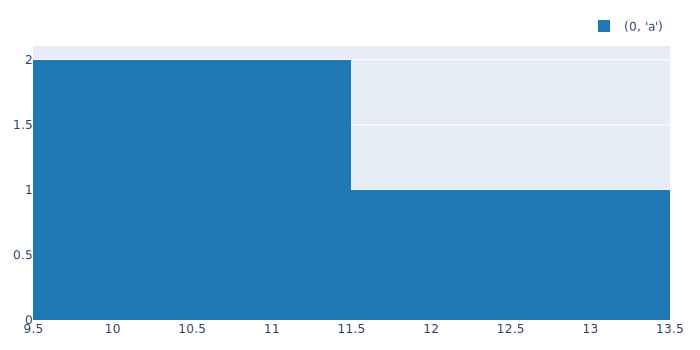

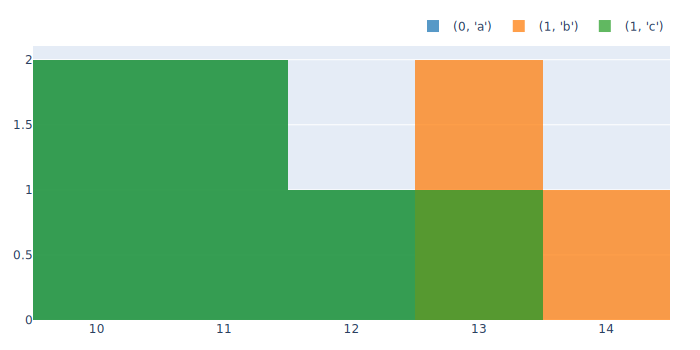

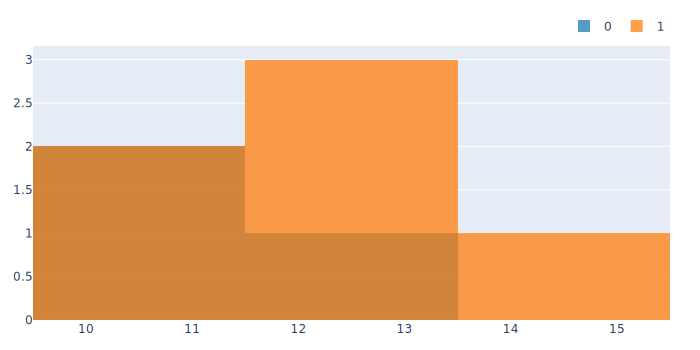

In [79]:
mapped_array[(0, 'a')].histplot().show_svg()
mapped_array.histplot().show_svg()
mapped_array_grouped.histplot().show_svg()

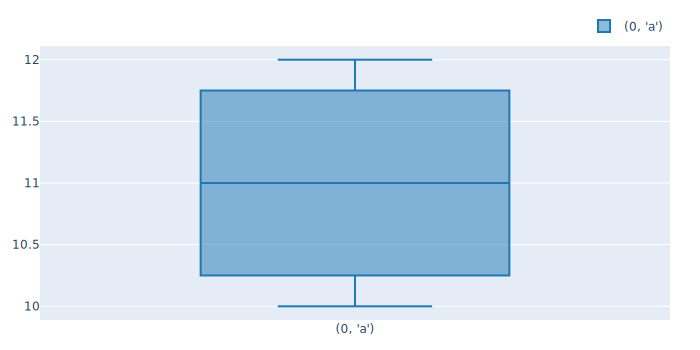

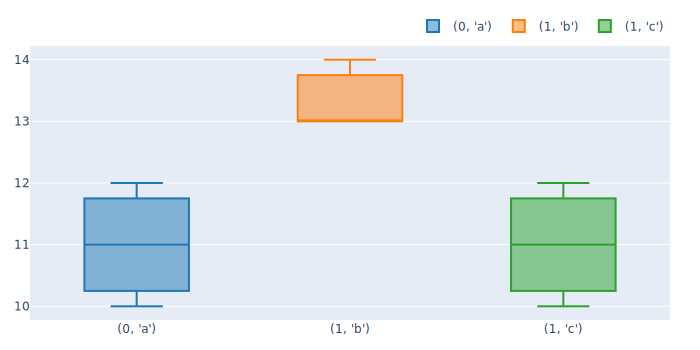

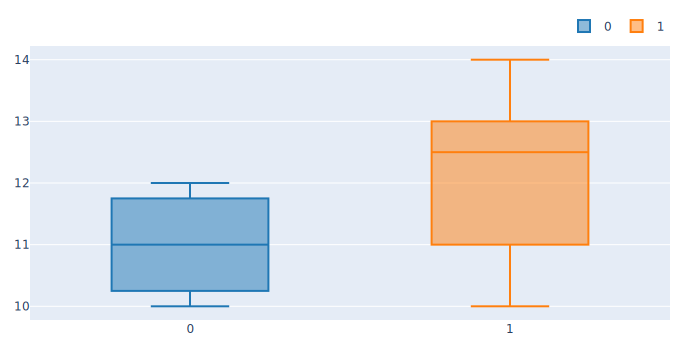

In [80]:
mapped_array[(0, 'a')].boxplot().show_svg()
mapped_array.boxplot().show_svg()
mapped_array_grouped.boxplot().show_svg()

## Records

In [85]:
print(records[(0, 'a')].values)
print(records[(0, 'a')].wrapper.columns)

print(records[(1, 'b')].values)
print(records[(1, 'b')].wrapper.columns)

print(records[[(0, 'a'), (0, 'a')]].values)
print(records[[(0, 'a'), (0, 'a')]].wrapper.columns)

print(records[[(0, 'a'), (1, 'b')]].values)
print(records[[(0, 'a'), (1, 'b')]].wrapper.columns)

%timeit big_records.iloc[0]
%timeit big_records.iloc[:]

[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)]
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
[(3, 0, 0, 13., 18.) (4, 1, 0, 14., 17.) (5, 2, 0, 13., 18.)]
MultiIndex([(1, 'b')],
           names=['lvl1', 'lvl2'])
[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (0, 0, 1, 10., 21.) (1, 1, 1, 11., 20.) (2, 2, 1, 12., 19.)]
MultiIndex([(0, 'a'),
            (0, 'a')],
           names=['lvl1', 'lvl2'])
[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.) (5, 2, 1, 13., 18.)]
MultiIndex([(0, 'a'),
            (1, 'b')],
           names=['lvl1', 'lvl2'])
770 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
14 ms ± 264 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [86]:
print(records_nosort[(0, 'a')].values)
print(records_nosort[(0, 'a')].wrapper.columns)

print(records_nosort[(1, 'b')].values)
print(records_nosort[(1, 'b')].wrapper.columns)

print(records_nosort[[(0, 'a'), (0, 'a')]].values)
print(records_nosort[[(0, 'a'), (0, 'a')]].wrapper.columns)

print(records_nosort[[(0, 'a'), (1, 'b')]].values)
print(records_nosort[[(0, 'a'), (1, 'b')]].wrapper.columns)

%timeit big_records_nosort.iloc[0]
%timeit big_records_nosort.iloc[:]

[(2, 2, 0, 12., 19.) (1, 1, 0, 11., 20.) (0, 0, 0, 10., 21.)]
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
[(5, 2, 0, 13., 18.) (4, 1, 0, 14., 17.) (3, 0, 0, 13., 18.)]
MultiIndex([(1, 'b')],
           names=['lvl1', 'lvl2'])
[(2, 2, 0, 12., 19.) (1, 1, 0, 11., 20.) (0, 0, 0, 10., 21.)
 (2, 2, 1, 12., 19.) (1, 1, 1, 11., 20.) (0, 0, 1, 10., 21.)]
MultiIndex([(0, 'a'),
            (0, 'a')],
           names=['lvl1', 'lvl2'])
[(2, 2, 0, 12., 19.) (1, 1, 0, 11., 20.) (0, 0, 0, 10., 21.)
 (5, 2, 1, 13., 18.) (4, 1, 1, 14., 17.) (3, 0, 1, 13., 18.)]
MultiIndex([(0, 'a'),
            (1, 'b')],
           names=['lvl1', 'lvl2'])
758 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
15.5 ms ± 169 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
print(records_grouped[0].wrapper.columns)  # indexing on groups, not columns!
print(records_grouped[0].wrapper.ndim)
print(records_grouped[0].wrapper.grouped_ndim)
print(records_grouped[0].wrapper.grouper.group_by)

print(records_grouped[1].wrapper.columns)
print(records_grouped[1].wrapper.ndim)
print(records_grouped[1].wrapper.grouped_ndim)
print(records_grouped[1].wrapper.grouper.group_by)

print(records_grouped[[0]].wrapper.columns)
print(records_grouped[[0]].wrapper.ndim)
print(records_grouped[[0]].wrapper.grouped_ndim)
print(records_grouped[[0]].wrapper.grouper.group_by)

print(records_grouped[[0, 1]].wrapper.columns)
print(records_grouped[[0, 1]].wrapper.ndim)
print(records_grouped[[0, 1]].wrapper.grouped_ndim)
print(records_grouped[[0, 1]].wrapper.grouper.group_by)

%timeit big_records_grouped.iloc[0]
%timeit big_records_grouped.iloc[:]

MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
1
1
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
1
Int64Index([1, 1, 1], dtype='int64', name='lvl1')
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0, 1, 1, 1], dtype='int64', name='lvl1')
6.02 ms ± 37.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.1 ms ± 87.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
print(records.wrapper.index)
print(records.wrapper.columns)
print(records.wrapper.ndim)
print(records.wrapper.grouper.group_by)

print(records_grouped.wrapper.index)
print(records_grouped.wrapper.columns)
print(records_grouped.wrapper.ndim)
print(records_grouped.wrapper.grouper.group_by)

Index(['x', 'y', 'z'], dtype='object')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
None
Index(['x', 'y', 'z'], dtype='object')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
Int64Index([0, 1, 1, 1], dtype='int64', name='lvl1')


In [89]:
print(records.values)

print(records.recarray)
%timeit big_records.recarray

[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.) (5, 2, 1, 13., 18.)
 (6, 0, 2, 12., 19.) (7, 1, 2, 11., 20.) (8, 2, 2, 10., 21.)]
[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.) (5, 2, 1, 13., 18.)
 (6, 0, 2, 12., 19.) (7, 1, 2, 11., 20.) (8, 2, 2, 10., 21.)]
3.26 µs ± 6.21 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [90]:
print(records.records)

   id  idx  col  some_field1  some_field2
0   0    0    0         10.0         21.0
1   1    1    0         11.0         20.0
2   2    2    0         12.0         19.0
3   3    0    1         13.0         18.0
4   4    1    1         14.0         17.0
5   5    2    1         13.0         18.0
6   6    0    2         12.0         19.0
7   7    1    2         11.0         20.0
8   8    2    2         10.0         21.0


In [91]:
print(records.is_sorted())
%timeit big_records.is_sorted()

print(records_nosort.is_sorted())
%timeit big_records_nosort.is_sorted()

print(records.is_sorted(incl_id=True))
%timeit big_records.is_sorted(incl_id=True)

print(records_nosort.is_sorted(incl_id=True))
%timeit big_records_nosort.is_sorted(incl_id=True)

True
1.07 ms ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
False
8.15 µs ± 24.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
True
1.56 ms ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
False
7.28 µs ± 15.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [92]:
print(records.sort().records_arr)
%timeit big_records.sort()

print(records_nosort.sort().records_arr)
%timeit big_records_nosort.sort()

print(records.sort(incl_id=True).records_arr)
%timeit big_records.sort(incl_id=True)

print(records_nosort.sort(incl_id=True).records_arr)
%timeit big_records_nosort.sort(incl_id=True)

[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.) (5, 2, 1, 13., 18.)
 (6, 0, 2, 12., 19.) (7, 1, 2, 11., 20.) (8, 2, 2, 10., 21.)]
1.24 ms ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[(2, 2, 0, 12., 19.) (1, 1, 0, 11., 20.) (0, 0, 0, 10., 21.)
 (5, 2, 1, 13., 18.) (4, 1, 1, 14., 17.) (3, 0, 1, 13., 18.)
 (8, 2, 2, 10., 21.) (7, 1, 2, 11., 20.) (6, 0, 2, 12., 19.)]
85.8 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.) (5, 2, 1, 13., 18.)
 (6, 0, 2, 12., 19.) (7, 1, 2, 11., 20.) (8, 2, 2, 10., 21.)]
1.76 ms ± 1.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[(0, 0, 0, 10., 21.) (1, 1, 0, 11., 20.) (2, 2, 0, 12., 19.)
 (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.) (5, 2, 1, 13., 18.)
 (6, 0, 2, 12., 19.) (7, 1, 2, 11., 20.) (8, 2, 2, 10., 21.)]
80 ms ± 1.41 ms per loop (mean ± std. dev. of 7

In [93]:
mask = records.values['some_field1'] >= records.values['some_field1'].mean()
print(records.filter_by_mask(mask).values)

big_mask = big_records.values['some_field1'] >= big_records.values['some_field1'].mean()
%timeit big_records.filter_by_mask(big_mask)

[(2, 2, 0, 12., 19.) (3, 0, 1, 13., 18.) (4, 1, 1, 14., 17.)
 (5, 2, 1, 13., 18.) (6, 0, 2, 12., 19.)]
9.41 ms ± 56.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [94]:
@njit
def map_nb(record):
    return record.some_field1 + record.some_field2 * 2

print(records.map(map_nb).sum())
print(records_grouped.map(map_nb).sum())
print(records_grouped.map(map_nb, group_by=False).sum())

%timeit vbt.records.MappedArray(\
    big_wrapper,\
    big_records_arr['some_field1'] + big_records_arr['some_field2'] * 2,\
    big_records_arr['col'],\
)
%timeit big_records.map(map_nb)  # faster

lvl1  lvl2
0     a       153.0
1     b       146.0
      c       153.0
      d         0.0
Name: sum, dtype: float64
lvl1
0    153.0
1    299.0
Name: sum, dtype: float64
lvl1  lvl2
0     a       153.0
1     b       146.0
      c       153.0
      d         0.0
Name: sum, dtype: float64
3.31 ms ± 54.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.99 ms ± 61.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [95]:
print(records.map_field('col').values)
print(records.map_field('idx').values)
print(records.map_field('some_field1').values)
print(records.map_field('some_field2').values)

print(records.map_field('some_field1').sum())
print(records_grouped.map_field('some_field1').sum())
print(records_grouped.map_field('some_field1', group_by=False).sum())

%timeit big_records.map_field('some_field1')

[0 0 0 1 1 1 2 2 2]
[0 1 2 0 1 2 0 1 2]
[10. 11. 12. 13. 14. 13. 12. 11. 10.]
[21. 20. 19. 18. 17. 18. 19. 20. 21.]
lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
Name: sum, dtype: float64
lvl1
0    33.0
1    73.0
Name: sum, dtype: float64
lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
Name: sum, dtype: float64
286 µs ± 3.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [96]:
print(records.map_array(records_arr['some_field1'] + records_arr['some_field2'] * 2).values)
print(records_grouped.map_array(records_arr['some_field1'] + records_arr['some_field2'] * 2).sum())
print(records_grouped.map_array(records_arr['some_field1'] + records_arr['some_field2'] * 2, group_by=False).sum())

%timeit big_records.map_array(big_records_arr['some_field1'] + big_records_arr['some_field2'] * 2)

[52. 51. 50. 49. 48. 49. 50. 51. 52.]
lvl1
0    153.0
1    299.0
Name: sum, dtype: float64
lvl1  lvl2
0     a       153.0
1     b       146.0
      c       153.0
      d         0.0
Name: sum, dtype: float64
2.95 ms ± 456 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [97]:
print(records.count())
print(records_grouped.count())
print(records_grouped.count(group_by=False))

%timeit big_records.count()
%timeit big_records_grouped.count()

lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
Name: count, dtype: int64
lvl1
0    3
1    6
Name: count, dtype: int64
lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
Name: count, dtype: int64
51.3 µs ± 376 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
49.4 µs ± 99.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [98]:
filter_mask = np.array([True, False, False, False, False, False, False, False, True])

print(records.filter_by_mask(filter_mask).count())
print(records_grouped.filter_by_mask(filter_mask).count())
print(records_grouped.filter_by_mask(filter_mask, group_by=False).count())

lvl1  lvl2
0     a       1
1     b       0
      c       1
      d       0
Name: count, dtype: int64
lvl1
0    1
1    1
Name: count, dtype: int64
lvl1  lvl2
0     a       1
1     b       0
      c       1
      d       0
Name: count, dtype: int64


In [99]:
filtered_records = records.filter_by_mask(filter_mask)
print(filtered_records.records)

   id  idx  col  some_field1  some_field2
0   0    0    0         10.0         21.0
1   8    2    2         10.0         21.0


In [100]:
print(filtered_records[(0, 'a')].records)
print(filtered_records[(0, 'a')].map_field('some_field1').values)
print(filtered_records[(0, 'a')].map_field('some_field1').min())
print(filtered_records[(0, 'a')].count())

   id  idx  col  some_field1  some_field2
0   0    0    0         10.0         21.0
[10.]
10.0
1


In [101]:
print(filtered_records[(1, 'b')].records)
print(filtered_records[(1, 'b')].map_field('some_field1').values)
print(filtered_records[(1, 'b')].map_field('some_field1').min())
print(filtered_records[(1, 'b')].count())

Empty DataFrame
Columns: [id, idx, col, some_field1, some_field2]
Index: []
[]
nan
0


In [102]:
print(filtered_records[(1, 'c')].records)
print(filtered_records[(1, 'c')].map_field('some_field1').values)
print(filtered_records[(1, 'c')].map_field('some_field1').min())
print(filtered_records[(1, 'c')].count())

   id  idx  col  some_field1  some_field2
0   8    2    0         10.0         21.0
[10.]
10.0
1


In [103]:
print(filtered_records[(1, 'd')].records)
print(filtered_records[(1, 'd')].map_field('some_field1').values)
print(filtered_records[(1, 'd')].map_field('some_field1').min())
print(filtered_records[(1, 'd')].count())

Empty DataFrame
Columns: [id, idx, col, some_field1, some_field2]
Index: []
[]
nan
0


## Drawdowns

In [10]:
ts = pd.DataFrame({
    'a': [2, 1, 3, 1, 4, 1], 
    'b': [1, 2, 1, 3, 1, 4],
    'c': [1, 2, 3, 2, 1, 2],
    'd': [1, 2, 3, 4, 5, 6]
}, index=[
    datetime(2020, 1, 1),
    datetime(2020, 1, 2),
    datetime(2020, 1, 3),
    datetime(2020, 1, 4),
    datetime(2020, 1, 5),
    datetime(2020, 1, 6)
])

np.random.seed(42)
big_ts = pd.DataFrame(np.random.randint(1, 10, size=(1000, 1000)))

In [11]:
drawdowns = vbt.Drawdowns.from_ts(ts, freq='1 days')
print(drawdowns.values.shape)

(6,)


In [12]:
big_drawdowns = vbt.Drawdowns.from_ts(big_ts, freq='1 days')
print(big_drawdowns.values.shape)

(99845,)


In [107]:
%timeit vbt.Drawdowns.from_ts(big_ts, freq='1 days')

6.18 ms ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [108]:
print(drawdowns.records)
print(drawdowns.ts)

print(drawdowns['a'].records)
print(drawdowns['a'].ts)

%timeit big_drawdowns.iloc[0]
%timeit big_drawdowns.iloc[:]

   id  col  start_idx  valley_idx  end_idx  status
0   0    0          0           1        2       1
1   1    0          2           3        4       1
2   2    0          4           5        5       0
3   3    1          1           2        3       1
4   4    1          3           4        5       1
5   5    2          2           4        5       0
            a  b  c  d
2020-01-01  2  1  1  1
2020-01-02  1  2  2  2
2020-01-03  3  1  3  3
2020-01-04  1  3  2  4
2020-01-05  4  1  1  5
2020-01-06  1  4  2  6
   id  col  start_idx  valley_idx  end_idx  status
0   0    0          0           1        2       1
1   1    0          2           3        4       1
2   2    0          4           5        5       0
2020-01-01    2
2020-01-02    1
2020-01-03    3
2020-01-04    1
2020-01-05    4
2020-01-06    1
Name: a, dtype: int64
1.31 ms ± 1.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.45 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [109]:
print(drawdowns.records_readable)

   Drawdown Id Column Start Date Valley Date   End Date     Status
0            0      a 2020-01-01  2020-01-02 2020-01-03  Recovered
1            1      a 2020-01-03  2020-01-04 2020-01-05  Recovered
2            2      a 2020-01-05  2020-01-06 2020-01-06     Active
3            3      b 2020-01-02  2020-01-03 2020-01-04  Recovered
4            4      b 2020-01-04  2020-01-05 2020-01-06  Recovered
5            5      c 2020-01-03  2020-01-05 2020-01-06     Active


In [110]:
print(drawdowns['a'].count())

print(drawdowns.count())
print(drawdowns.count(group_by=group_by))

3
a    3
b    2
c    1
d    0
Name: count, dtype: int64
group
first     5
second    1
Name: count, dtype: int64


In [111]:
print(drawdowns['a'].start_value.to_pd())
print(drawdowns.start_value.to_pd())

%timeit big_drawdowns.start_value

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    2.0
2020-01-04    NaN
2020-01-05    3.0
2020-01-06    4.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  2.0  NaN  NaN NaN
2020-01-04  NaN  2.0  NaN NaN
2020-01-05  3.0  NaN  NaN NaN
2020-01-06  4.0  3.0  3.0 NaN
630 µs ± 30.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [112]:
print(drawdowns['a'].valley_value.to_pd())
print(drawdowns.valley_value.to_pd())

%timeit big_drawdowns.valley_value

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    1.0
2020-01-04    NaN
2020-01-05    1.0
2020-01-06    1.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  1.0  NaN  NaN NaN
2020-01-04  NaN  1.0  NaN NaN
2020-01-05  1.0  NaN  NaN NaN
2020-01-06  1.0  1.0  1.0 NaN
613 µs ± 6.03 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [113]:
print(drawdowns['a'].end_value.to_pd())
print(drawdowns.end_value.to_pd())

%timeit big_drawdowns.end_value

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    3.0
2020-01-04    NaN
2020-01-05    4.0
2020-01-06    1.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  3.0  NaN  NaN NaN
2020-01-04  NaN  3.0  NaN NaN
2020-01-05  4.0  NaN  NaN NaN
2020-01-06  1.0  4.0  2.0 NaN
616 µs ± 6.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [114]:
print(drawdowns['a'].drawdown.to_pd())
print(drawdowns.drawdown.to_pd())

%timeit big_drawdowns.drawdown

2020-01-01         NaN
2020-01-02         NaN
2020-01-03   -0.500000
2020-01-04         NaN
2020-01-05   -0.666667
2020-01-06   -0.750000
Name: a, dtype: float64
                   a         b         c   d
2020-01-01       NaN       NaN       NaN NaN
2020-01-02       NaN       NaN       NaN NaN
2020-01-03 -0.500000       NaN       NaN NaN
2020-01-04       NaN -0.500000       NaN NaN
2020-01-05 -0.666667       NaN       NaN NaN
2020-01-06 -0.750000 -0.666667 -0.666667 NaN
766 µs ± 4.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [115]:
print(drawdowns['a'].avg_drawdown())
print(drawdowns.avg_drawdown())
%timeit big_drawdowns.avg_drawdown()

print(drawdowns.avg_drawdown(group_by=group_by))
%timeit big_drawdowns.avg_drawdown(group_by=big_group_by)

-0.6388888888888888
a   -0.638889
b   -0.583333
c   -0.666667
d         NaN
Name: avg_drawdown, dtype: float64
1.86 ms ± 49.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first    -0.616667
second   -0.666667
Name: avg_drawdown, dtype: float64
3.94 ms ± 30 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [116]:
print(drawdowns['a'].max_drawdown())
print(drawdowns.max_drawdown())
%timeit big_drawdowns.max_drawdown()

print(drawdowns.max_drawdown(group_by=group_by))
%timeit big_drawdowns.max_drawdown(group_by=big_group_by)

-0.75
a   -0.750000
b   -0.666667
c   -0.666667
d         NaN
Name: max_drawdown, dtype: float64
1.84 ms ± 36.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first    -0.750000
second   -0.666667
Name: max_drawdown, dtype: float64
4.05 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [117]:
print(drawdowns['a'].duration.to_pd())
print(drawdowns.duration.to_pd())

%timeit big_drawdowns.duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    2.0
2020-01-04    NaN
2020-01-05    2.0
2020-01-06    1.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  2.0  NaN  NaN NaN
2020-01-04  NaN  2.0  NaN NaN
2020-01-05  2.0  NaN  NaN NaN
2020-01-06  1.0  2.0  3.0 NaN
397 µs ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [118]:
print(drawdowns['a'].avg_duration())
print(drawdowns.avg_duration())
%timeit big_drawdowns.avg_duration()

print(drawdowns.avg_duration(group_by=group_by))
%timeit big_drawdowns.avg_duration(group_by=big_group_by)

1 days 16:00:00
a   1 days 16:00:00
b   2 days 00:00:00
c   3 days 00:00:00
d               NaT
Name: avg_duration, dtype: timedelta64[ns]
1.52 ms ± 28.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
group
first    1 days 19:12:00
second   3 days 00:00:00
Name: avg_duration, dtype: timedelta64[ns]
3.41 ms ± 25.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [119]:
print(drawdowns['a'].max_duration())
print(drawdowns.max_duration())
%timeit big_drawdowns.max_duration()

print(drawdowns.max_duration(group_by=group_by))
%timeit big_drawdowns.max_duration(group_by=big_group_by)

2 days 00:00:00
a   2 days
b   2 days
c   3 days
d      NaT
Name: max_duration, dtype: timedelta64[ns]
1.48 ms ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
group
first    2 days
second   3 days
Name: max_duration, dtype: timedelta64[ns]
3.38 ms ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [120]:
print(drawdowns['a'].coverage())
print(drawdowns.coverage())
%timeit big_drawdowns.coverage()

print(drawdowns.coverage(group_by=group_by))
%timeit big_drawdowns.coverage(group_by=big_group_by)

0.8333333333333334
a    0.833333
b    0.666667
c    0.500000
d    0.000000
Name: coverage, dtype: float64
1.45 ms ± 13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
group
first     0.75
second    0.25
Name: coverage, dtype: float64
4.46 ms ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [122]:
print(drawdowns['a'].decline_duration.to_pd())
print(drawdowns.decline_duration.to_pd())

%timeit big_drawdowns.decline_duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    1.0
2020-01-04    NaN
2020-01-05    1.0
2020-01-06    1.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  1.0  NaN  NaN NaN
2020-01-04  NaN  1.0  NaN NaN
2020-01-05  1.0  NaN  NaN NaN
2020-01-06  1.0  1.0  2.0 NaN
398 µs ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [123]:
print(drawdowns['a'].status.to_pd())
print(drawdowns.status.to_pd())

%timeit big_drawdowns.status

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    1.0
2020-01-04    NaN
2020-01-05    1.0
2020-01-06    0.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  1.0  NaN  NaN NaN
2020-01-04  NaN  1.0  NaN NaN
2020-01-05  1.0  NaN  NaN NaN
2020-01-06  0.0  1.0  0.0 NaN
297 µs ± 2.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [124]:
print(drawdowns.active)
print(drawdowns['a'].active.records)
print(drawdowns.active['a'].records)
print(drawdowns.active.records)

%timeit big_drawdowns.active

Drawdowns(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7fa150ca8b00> of shape (6, 4)",
    "records_arr": "<numpy.ndarray object at 0x7fa193a3c620> of shape (2,)",
    "idx_field": "end_idx",
    "ts": "<pandas.core.frame.DataFrame object at 0x7fa170f17da0> of shape (6, 4)"
}))
   id  col  start_idx  valley_idx  end_idx  status
0   2    0          4           5        5       0
   id  col  start_idx  valley_idx  end_idx  status
0   2    0          4           5        5       0
   id  col  start_idx  valley_idx  end_idx  status
0   2    0          4           5        5       0
1   5    2          2           4        5       0
702 µs ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [125]:
print(drawdowns['a'].active_rate())
print(drawdowns.active_rate())
%timeit big_drawdowns.active_rate()

print(drawdowns.active_rate(group_by=group_by))
%timeit big_drawdowns.active_rate(group_by=big_group_by)

0.3333333333333333
a    0.333333
b    0.000000
c    1.000000
d         NaN
Name: active_rate, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/drawdowns.py:350: RuntimeWarning:

invalid value encountered in true_divide



902 µs ± 4.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
group
first     0.2
second    1.0
Name: active_rate, dtype: float64
6.12 ms ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [126]:
print(drawdowns.recovered)
print(drawdowns['a'].recovered.records)
print(drawdowns.recovered['a'].records)
print(drawdowns.recovered.records)

%timeit big_drawdowns.recovered

Drawdowns(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7fa150ca8b00> of shape (6, 4)",
    "records_arr": "<numpy.ndarray object at 0x7fa1273fe8a0> of shape (4,)",
    "idx_field": "end_idx",
    "ts": "<pandas.core.frame.DataFrame object at 0x7fa170f17da0> of shape (6, 4)"
}))
   id  col  start_idx  valley_idx  end_idx  status
0   0    0          0           1        2       1
1   1    0          2           3        4       1
   id  col  start_idx  valley_idx  end_idx  status
0   0    0          0           1        2       1
1   1    0          2           3        4       1
   id  col  start_idx  valley_idx  end_idx  status
0   0    0          0           1        2       1
1   1    0          2           3        4       1
2   3    1          1           2        3       1
3   4    1          3           4        5       1
1.91 ms ± 71.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [127]:
print(drawdowns['a'].recovered_rate())
print(drawdowns.recovered_rate())
%timeit big_drawdowns.recovered_rate()

print(drawdowns.recovered_rate(group_by=group_by))
%timeit big_drawdowns.recovered_rate(group_by=big_group_by)

0.6666666666666666
a    0.666667
b    1.000000
c    0.000000
d         NaN
Name: recovered_rate, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/drawdowns.py:365: RuntimeWarning:

invalid value encountered in true_divide



1.79 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.8
second    0.0
Name: recovered_rate, dtype: float64
6.95 ms ± 19.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [129]:
print(drawdowns['a'].active_drawdown())
print(drawdowns.active_drawdown())

%timeit big_drawdowns.active_drawdown()

-0.75
a   -0.750000
b         NaN
c   -0.333333
d         NaN
Name: active_drawdown, dtype: float64
4.32 ms ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [130]:
print(drawdowns['a'].active_duration())
print(drawdowns.active_duration())

%timeit big_drawdowns.active_duration()

1 days 00:00:00
a   1 days
b      NaT
c   3 days
d      NaT
Name: active_duration, dtype: timedelta64[ns]
1.32 ms ± 4.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [132]:
print(drawdowns['a'].active_recovery_return())
print(drawdowns.active_recovery_return())

%timeit big_drawdowns.active_recovery_return()

0.0
a    0.0
b    NaN
c    1.0
d    NaN
Name: active_recovery_return, dtype: float64
2.11 ms ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [133]:
print(drawdowns['a'].recovery_return.to_pd())
print(drawdowns.recovery_return.to_pd())

%timeit big_drawdowns.recovery_return

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    2.0
2020-01-04    NaN
2020-01-05    3.0
2020-01-06    0.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  2.0  NaN  NaN NaN
2020-01-04  NaN  2.0  NaN NaN
2020-01-05  3.0  NaN  NaN NaN
2020-01-06  0.0  3.0  1.0 NaN
785 µs ± 37.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [134]:
print(drawdowns['a'].recovery_duration.to_pd())
print(drawdowns.recovery_duration.to_pd())

%timeit big_drawdowns.recovery_duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    1.0
2020-01-04    NaN
2020-01-05    1.0
2020-01-06    0.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  1.0  NaN  NaN NaN
2020-01-04  NaN  1.0  NaN NaN
2020-01-05  1.0  NaN  NaN NaN
2020-01-06  0.0  1.0  1.0 NaN
379 µs ± 923 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [135]:
print(drawdowns['a'].recovery_duration_ratio.to_pd())
print(drawdowns.recovery_duration_ratio.to_pd())

%timeit big_drawdowns.recovery_duration_ratio

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    0.5
2020-01-04    NaN
2020-01-05    0.5
2020-01-06    0.0
Name: a, dtype: float64
              a    b         c   d
2020-01-01  NaN  NaN       NaN NaN
2020-01-02  NaN  NaN       NaN NaN
2020-01-03  0.5  NaN       NaN NaN
2020-01-04  NaN  0.5       NaN NaN
2020-01-05  0.5  NaN       NaN NaN
2020-01-06  0.0  0.5  0.333333 NaN
427 µs ± 446 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
print(drawdowns['a'].stats())
%timeit big_drawdowns[0].stats(silence_warnings=True)

print(drawdowns.stats(column='a'))
%timeit big_drawdowns.stats(column=0, silence_warnings=True)

print(drawdowns.stats())
%timeit big_drawdowns.stats(silence_warnings=True)

Start                          2020-01-01 00:00:00
End                            2020-01-06 00:00:00
Period                             6 days 00:00:00
Total Records                                    3
Total Recovered Drawdowns                        2
Total Active Drawdowns                           1
Active Drawdown [%]                           75.0
Active Duration                    1 days 00:00:00
Active Recovery [%]                            0.0
Active Recovery Return [%]                     0.0
Active Recovery Duration           0 days 00:00:00
Max Drawdown [%]                         66.666667
Avg Drawdown [%]                         58.333333
Max Drawdown Duration              2 days 00:00:00
Avg Drawdown Duration              2 days 00:00:00
Max Recovery Return [%]                      300.0
Avg Recovery Return [%]                      250.0
Max Recovery Duration              1 days 00:00:00
Avg Recovery Duration              1 days 00:00:00
Avg Recovery Duration Ratio    

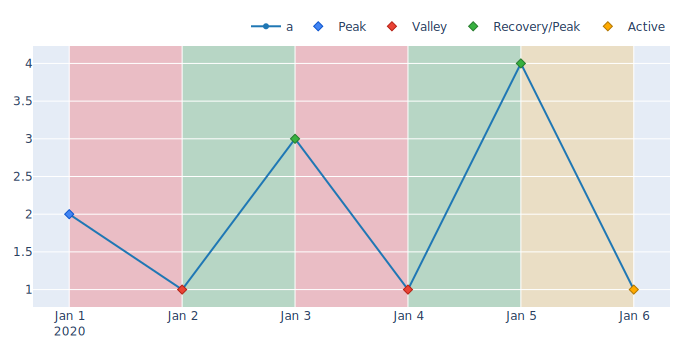

In [136]:
drawdowns['a'].plot().show_svg()

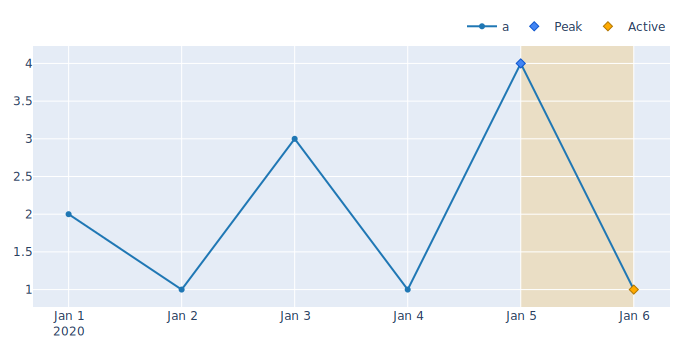

In [137]:
drawdowns.plot(column='a', top_n=1).show_svg()

## Orders

In [8]:
close = pd.Series([1, 2, 3, 4, 5, 6, 7, 8], index=[
    datetime(2020, 1, 1),
    datetime(2020, 1, 2),
    datetime(2020, 1, 3),
    datetime(2020, 1, 4),
    datetime(2020, 1, 5),
    datetime(2020, 1, 6),
    datetime(2020, 1, 7),
    datetime(2020, 1, 8)
]).vbt.tile(4, keys=['a', 'b', 'c', 'd'])
print(close)

big_close = pd.DataFrame(np.random.uniform(1, 10, size=(1000, 1000)))

            a  b  c  d
2020-01-01  1  1  1  1
2020-01-02  2  2  2  2
2020-01-03  3  3  3  3
2020-01-04  4  4  4  4
2020-01-05  5  5  5  5
2020-01-06  6  6  6  6
2020-01-07  7  7  7  7
2020-01-08  8  8  8  8


In [11]:
from vectorbt.portfolio.enums import order_dt

records_arr = np.asarray([
    (0, 0, 0, 1. , 1., 0.01 , 0), (1, 1, 0, 0.1, 2., 0.002, 0),
    (2, 2, 0, 1. , 3., 0.03 , 1), (3, 3, 0, 0.1, 4., 0.004, 1),
    (4, 5, 0, 1. , 6., 0.06 , 0), (5, 6, 0, 1. , 7., 0.07 , 1),
    (6, 7, 0, 2. , 8., 0.16 , 0), (7, 0, 1, 1. , 1., 0.01 , 1),
    (8, 1, 1, 0.1, 2., 0.002, 1), (9, 2, 1, 1. , 3., 0.03 , 0),
    (10, 3, 1, 0.1, 4., 0.004, 0), (11, 5, 1, 1. , 6., 0.06 , 1),
    (12, 6, 1, 1. , 7., 0.07 , 0), (13, 7, 1, 2. , 8., 0.16 , 1),
    (14, 0, 2, 1. , 1., 0.01 , 0), (15, 1, 2, 0.1, 2., 0.002, 0),
    (16, 2, 2, 1. , 3., 0.03 , 1), (17, 3, 2, 0.1, 4., 0.004, 1),
    (18, 5, 2, 1. , 6., 0.06 , 0), (19, 6, 2, 2. , 7., 0.14 , 1),
    (20, 7, 2, 2. , 8., 0.16 , 0)
], dtype=order_dt)
print(records_arr.shape)

wrapper = vbt.ArrayWrapper.from_obj(close, freq='1 days')
orders = vbt.Orders(wrapper, records_arr, close)
orders_grouped = vbt.Orders(wrapper.regroup(group_by), records_arr, close)

(21,)


In [12]:
big_records_arr = np.asarray(list(zip(*(
    np.arange(1000000),
    np.tile(np.arange(1000), 1000),
    np.repeat(np.arange(1000), 1000),
    np.full(1000000, 10),
    np.random.uniform(1, 10, size=1000000),
    np.full(1000000, 1),
    np.full(1000000, 1)
))), dtype=order_dt)
big_records_arr['side'][::2] = 0
print(big_records_arr.shape)

big_wrapper = vbt.ArrayWrapper.from_obj(big_close, freq='1 days')
big_orders = vbt.Orders(big_wrapper, big_records_arr, big_close)
big_orders_grouped = vbt.Orders(big_wrapper.copy(group_by=big_group_by), big_records_arr, big_close)

(1000000,)


In [141]:
print(orders.records)
print(orders.close)

print(orders['a'].records)
print(orders['a'].close)

%timeit big_orders.iloc[0]
%timeit big_orders.iloc[:]

%timeit big_orders_grouped.iloc[0]
%timeit big_orders_grouped.iloc[:]

    id  idx  col  size  price   fees  side
0    0    0    0   1.0    1.0  0.010     0
1    1    1    0   0.1    2.0  0.002     0
2    2    2    0   1.0    3.0  0.030     1
3    3    3    0   0.1    4.0  0.004     1
4    4    5    0   1.0    6.0  0.060     0
5    5    6    0   1.0    7.0  0.070     1
6    6    7    0   2.0    8.0  0.160     0
7    7    0    1   1.0    1.0  0.010     1
8    8    1    1   0.1    2.0  0.002     1
9    9    2    1   1.0    3.0  0.030     0
10  10    3    1   0.1    4.0  0.004     0
11  11    5    1   1.0    6.0  0.060     1
12  12    6    1   1.0    7.0  0.070     0
13  13    7    1   2.0    8.0  0.160     1
14  14    0    2   1.0    1.0  0.010     0
15  15    1    2   0.1    2.0  0.002     0
16  16    2    2   1.0    3.0  0.030     1
17  17    3    2   0.1    4.0  0.004     1
18  18    5    2   1.0    6.0  0.060     0
19  19    6    2   2.0    7.0  0.140     1
20  20    7    2   2.0    8.0  0.160     0
            a  b  c  d
2020-01-01  1  1  1  1
2020-01-

In [142]:
print(orders.records_readable)

    Order Id       Date Column  Size  Price   Fees  Side
0          0 2020-01-01      a   1.0    1.0  0.010   Buy
1          1 2020-01-02      a   0.1    2.0  0.002   Buy
2          2 2020-01-03      a   1.0    3.0  0.030  Sell
3          3 2020-01-04      a   0.1    4.0  0.004  Sell
4          4 2020-01-06      a   1.0    6.0  0.060   Buy
5          5 2020-01-07      a   1.0    7.0  0.070  Sell
6          6 2020-01-08      a   2.0    8.0  0.160   Buy
7          7 2020-01-01      b   1.0    1.0  0.010  Sell
8          8 2020-01-02      b   0.1    2.0  0.002  Sell
9          9 2020-01-03      b   1.0    3.0  0.030   Buy
10        10 2020-01-04      b   0.1    4.0  0.004   Buy
11        11 2020-01-06      b   1.0    6.0  0.060  Sell
12        12 2020-01-07      b   1.0    7.0  0.070   Buy
13        13 2020-01-08      b   2.0    8.0  0.160  Sell
14        14 2020-01-01      c   1.0    1.0  0.010   Buy
15        15 2020-01-02      c   0.1    2.0  0.002   Buy
16        16 2020-01-03      c 

In [143]:
print(orders['a'].size.to_pd())
print(orders.size.to_pd())

%timeit big_orders.size

2020-01-01    1.0
2020-01-02    0.1
2020-01-03    1.0
2020-01-04    0.1
2020-01-05    NaN
2020-01-06    1.0
2020-01-07    1.0
2020-01-08    2.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  1.0  1.0  1.0 NaN
2020-01-02  0.1  0.1  0.1 NaN
2020-01-03  1.0  1.0  1.0 NaN
2020-01-04  0.1  0.1  0.1 NaN
2020-01-05  NaN  NaN  NaN NaN
2020-01-06  1.0  1.0  1.0 NaN
2020-01-07  1.0  1.0  2.0 NaN
2020-01-08  2.0  2.0  2.0 NaN
294 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [144]:
print(orders['a'].price.to_pd())
print(orders.price.to_pd())

%timeit big_orders.price

2020-01-01    1.0
2020-01-02    2.0
2020-01-03    3.0
2020-01-04    4.0
2020-01-05    NaN
2020-01-06    6.0
2020-01-07    7.0
2020-01-08    8.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  1.0  1.0  1.0 NaN
2020-01-02  2.0  2.0  2.0 NaN
2020-01-03  3.0  3.0  3.0 NaN
2020-01-04  4.0  4.0  4.0 NaN
2020-01-05  NaN  NaN  NaN NaN
2020-01-06  6.0  6.0  6.0 NaN
2020-01-07  7.0  7.0  7.0 NaN
2020-01-08  8.0  8.0  8.0 NaN
293 µs ± 802 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [145]:
print(orders['a'].fees.to_pd())
print(orders.fees.to_pd())

%timeit big_orders.fees

2020-01-01    0.010
2020-01-02    0.002
2020-01-03    0.030
2020-01-04    0.004
2020-01-05      NaN
2020-01-06    0.060
2020-01-07    0.070
2020-01-08    0.160
Name: a, dtype: float64
                a      b      c   d
2020-01-01  0.010  0.010  0.010 NaN
2020-01-02  0.002  0.002  0.002 NaN
2020-01-03  0.030  0.030  0.030 NaN
2020-01-04  0.004  0.004  0.004 NaN
2020-01-05    NaN    NaN    NaN NaN
2020-01-06  0.060  0.060  0.060 NaN
2020-01-07  0.070  0.070  0.140 NaN
2020-01-08  0.160  0.160  0.160 NaN
293 µs ± 261 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [146]:
print(orders['a'].side.to_pd())
print(orders.side.to_pd())

%timeit big_orders.side

2020-01-01    0.0
2020-01-02    0.0
2020-01-03    1.0
2020-01-04    1.0
2020-01-05    NaN
2020-01-06    0.0
2020-01-07    1.0
2020-01-08    0.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  0.0  1.0  0.0 NaN
2020-01-02  0.0  1.0  0.0 NaN
2020-01-03  1.0  0.0  1.0 NaN
2020-01-04  1.0  0.0  1.0 NaN
2020-01-05  NaN  NaN  NaN NaN
2020-01-06  0.0  1.0  0.0 NaN
2020-01-07  1.0  0.0  1.0 NaN
2020-01-08  0.0  1.0  0.0 NaN
298 µs ± 273 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [147]:
print(orders.buy)
print(orders['a'].buy.records)
print(orders.buy['a'].records)
print(orders.buy.records)

%timeit big_orders.buy

Orders(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7fa1933614e0> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7fa1018ba030> of shape (11,)",
    "idx_field": "idx",
    "close": "<pandas.core.frame.DataFrame object at 0x7fa193aff5c0> of shape (8, 4)"
}))
   id  idx  col  size  price   fees  side
0   0    0    0   1.0    1.0  0.010     0
1   1    1    0   0.1    2.0  0.002     0
2   4    5    0   1.0    6.0  0.060     0
3   6    7    0   2.0    8.0  0.160     0
   id  idx  col  size  price   fees  side
0   0    0    0   1.0    1.0  0.010     0
1   1    1    0   0.1    2.0  0.002     0
2   4    5    0   1.0    6.0  0.060     0
3   6    7    0   2.0    8.0  0.160     0
    id  idx  col  size  price   fees  side
0    0    0    0   1.0    1.0  0.010     0
1    1    1    0   0.1    2.0  0.002     0
2    4    5    0   1.0    6.0  0.060     0
3    6    7    0   2.0    8.0  0.160     0
4    9    2    1   1.0    3.0  0.030     0
5   10    

In [148]:
print(orders['a'].buy_rate())
print(orders.buy_rate())
%timeit big_orders.buy_rate()

print(orders.buy_rate(group_by=group_by))
%timeit big_orders.buy_rate(group_by=big_group_by)

0.5714285714285714
a    0.571429
b    0.428571
c    0.571429
d         NaN
Name: buy_rate, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/orders.py:213: RuntimeWarning:

invalid value encountered in true_divide



15.1 ms ± 658 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.500000
second    0.571429
Name: buy_rate, dtype: float64
21.7 ms ± 666 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [149]:
print(orders.sell)
print(orders['a'].sell.records)
print(orders.sell['a'].records)
print(orders.sell.records)

%timeit big_orders.sell

Orders(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7fa1933614e0> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7f9fbbd993a0> of shape (10,)",
    "idx_field": "idx",
    "close": "<pandas.core.frame.DataFrame object at 0x7fa193aff5c0> of shape (8, 4)"
}))
   id  idx  col  size  price   fees  side
0   2    2    0   1.0    3.0  0.030     1
1   3    3    0   0.1    4.0  0.004     1
2   5    6    0   1.0    7.0  0.070     1
   id  idx  col  size  price   fees  side
0   2    2    0   1.0    3.0  0.030     1
1   3    3    0   0.1    4.0  0.004     1
2   5    6    0   1.0    7.0  0.070     1
   id  idx  col  size  price   fees  side
0   2    2    0   1.0    3.0  0.030     1
1   3    3    0   0.1    4.0  0.004     1
2   5    6    0   1.0    7.0  0.070     1
3   7    0    1   1.0    1.0  0.010     1
4   8    1    1   0.1    2.0  0.002     1
5  11    5    1   1.0    6.0  0.060     1
6  13    7    1   2.0    8.0  0.160     1
7  16    2    2 

In [150]:
print(orders['a'].sell_rate())
print(orders.sell_rate())
%timeit big_orders.sell_rate()

print(orders.sell_rate(group_by=group_by))
%timeit big_orders.sell_rate(group_by=big_group_by)

0.42857142857142855
a    0.428571
b    0.571429
c    0.428571
d         NaN
Name: sell_rate, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/orders.py:227: RuntimeWarning:

invalid value encountered in true_divide



15.8 ms ± 858 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.500000
second    0.428571
Name: sell_rate, dtype: float64
20.8 ms ± 326 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
print(orders['a'].stats())
%timeit big_orders[0].stats(silence_warnings=True)

print(orders.stats(column='a'))
%timeit big_orders.stats(column=0, silence_warnings=True)

print(orders.stats())
%timeit big_orders.stats(silence_warnings=True)

Start                2020-01-01 00:00:00
End                  2020-01-08 00:00:00
Period                   8 days 00:00:00
Total Records                          7
Total Buy Orders                       4
Total Sell Orders                      3
Max Size                             2.0
Min Size                             0.1
Avg Size                        0.885714
Avg Buy Size                       1.025
Avg Sell Size                        0.7
Avg Buy Price                       4.25
Avg Sell Price                  4.666667
Total Fees                         0.336
Min Fees                           0.002
Max Fees                            0.16
Avg Fees                           0.048
Avg Buy Fees                       0.058
Avg Sell Fees                   0.034667
Name: a, dtype: object
14.2 ms ± 34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Start                2020-01-01 00:00:00
End                  2020-01-08 00:00:00
Period                   8 days 00:00:00
Total

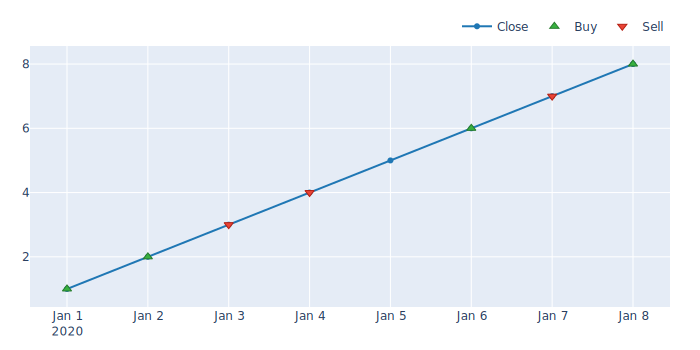

In [151]:
orders['a'].plot().show_svg()

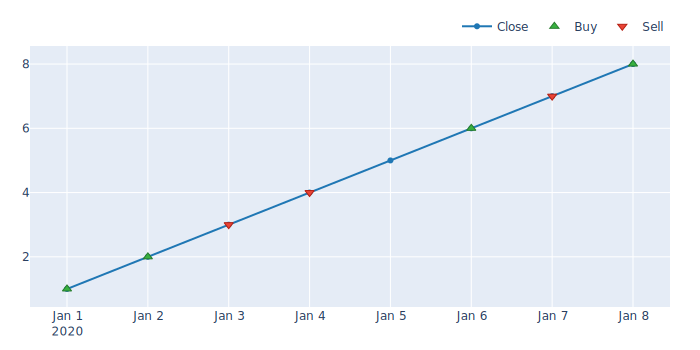

In [152]:
orders.plot(column='a').show_svg()

## Trades

In [13]:
trades = vbt.Trades.from_orders(orders)
trades_grouped = vbt.Trades.from_orders(orders_grouped)
print(trades.values.shape)

(13,)


In [14]:
big_trades = vbt.Trades.from_orders(big_orders)
big_trades_grouped = vbt.Trades.from_orders(big_orders_grouped)
print(big_trades.values.shape)

(500000,)


In [155]:
%timeit vbt.Trades.from_orders(big_orders)

10.4 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [156]:
print(trades.records)
print(trades.close)

print(trades['a'].records)
print(trades['a'].close)

%timeit big_trades.iloc[0]
%timeit big_trades.iloc[:]

%timeit big_trades_grouped.iloc[0]
%timeit big_trades_grouped.iloc[:]

    id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0    0   1.0          0     1.090909    0.010909         2         3.0   
1    1    0   0.1          0     1.090909    0.001091         3         4.0   
2    2    0   1.0          5     6.000000    0.060000         6         7.0   
3    3    0   2.0          7     8.000000    0.160000         7         8.0   
4    4    1   1.0          0     1.090909    0.010909         2         3.0   
5    5    1   0.1          0     1.090909    0.001091         3         4.0   
6    6    1   1.0          5     6.000000    0.060000         6         7.0   
7    7    1   2.0          7     8.000000    0.160000         7         8.0   
8    8    2   1.0          0     1.090909    0.010909         2         3.0   
9    9    2   0.1          0     1.090909    0.001091         3         4.0   
10  10    2   1.0          5     6.000000    0.060000         6         7.0   
11  11    2   1.0          6     7.000000    0.07000

In [157]:
print(trades.records_readable)

    Trade Id Column  Size Entry Date  Avg. Entry Price  Entry Fees  Exit Date  \
0          0      a   1.0 2020-01-01          1.090909    0.010909 2020-01-03   
1          1      a   0.1 2020-01-01          1.090909    0.001091 2020-01-04   
2          2      a   1.0 2020-01-06          6.000000    0.060000 2020-01-07   
3          3      a   2.0 2020-01-08          8.000000    0.160000 2020-01-08   
4          4      b   1.0 2020-01-01          1.090909    0.010909 2020-01-03   
5          5      b   0.1 2020-01-01          1.090909    0.001091 2020-01-04   
6          6      b   1.0 2020-01-06          6.000000    0.060000 2020-01-07   
7          7      b   2.0 2020-01-08          8.000000    0.160000 2020-01-08   
8          8      c   1.0 2020-01-01          1.090909    0.010909 2020-01-03   
9          9      c   0.1 2020-01-01          1.090909    0.001091 2020-01-04   
10        10      c   1.0 2020-01-06          6.000000    0.060000 2020-01-07   
11        11      c   1.0 20

In [158]:
print(trades['a'].count())
print(trades.count())
%timeit big_trades.count()

print(trades_grouped.count())
%timeit big_trades_grouped.count()

4
a    4
b    4
c    5
d    0
Name: count, dtype: int64
50.3 µs ± 917 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
group
first     8
second    5
Name: count, dtype: int64
49.3 µs ± 643 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [159]:
print(trades['a'].duration.to_pd(ignore_index=True))
print(trades.duration.to_pd(ignore_index=True))

%timeit big_trades.duration

0    2.0
1    3.0
2    1.0
3    0.0
Name: a, dtype: float64
     a    b    c   d
0  2.0  2.0  2.0 NaN
1  3.0  3.0  3.0 NaN
2  1.0  1.0  1.0 NaN
3  0.0  0.0  1.0 NaN
4  NaN  NaN  0.0 NaN
1.73 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [160]:
print(trades['a'].pnl.to_pd(ignore_index=True))
print(trades.pnl.to_pd(ignore_index=True))

%timeit big_trades.pnl

0    1.868182
1    0.285818
2    0.870000
3   -0.160000
Name: a, dtype: float64
          a      b         c   d
0  1.868182 -1.950  1.868182 NaN
1  0.285818 -0.296  0.285818 NaN
2  0.870000 -1.130  0.870000 NaN
3 -0.160000 -0.160 -1.150000 NaN
4       NaN    NaN -0.080000 NaN
304 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [161]:
print(trades['a'].returns.to_pd(ignore_index=True))
print(trades.returns.to_pd(ignore_index=True))

%timeit big_trades.returns

0    1.7125
1    2.6200
2    0.1450
3   -0.0100
Name: a, dtype: float64
        a         b         c   d
0  1.7125 -1.787500  1.712500 NaN
1  2.6200 -2.713333  2.620000 NaN
2  0.1450 -0.188333  0.145000 NaN
3 -0.0100 -0.010000 -0.164286 NaN
4     NaN       NaN -0.010000 NaN
296 µs ± 2.89 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [162]:
print(trades.winning)
print(trades['a'].winning.records)
print(trades.winning['a'].records)
print(trades.winning.records)

%timeit big_trades.winning

Trades(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7fa1933614e0> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7fa153489df0> of shape (6,)",
    "idx_field": "exit_idx",
    "close": "<pandas.core.frame.DataFrame object at 0x7fa193361860> of shape (8, 4)"
}))
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   0    0   1.0          0     1.090909    0.010909         2         3.0   
1   1    0   0.1          0     1.090909    0.001091         3         4.0   
2   2    0   1.0          5     6.000000    0.060000         6         7.0   

   exit_fees       pnl  return  direction  status  position_id  
0      0.030  1.868182  1.7125          0       1            0  
1      0.004  0.285818  2.6200          0       1            0  
2      0.070  0.870000  0.1450          0       1            1  
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   0    0   1.0          0     1

In [163]:
print(trades['a'].win_rate())
print(trades.win_rate())
%timeit big_trades.win_rate()

print(trades.win_rate(group_by=group_by))
%timeit big_trades.win_rate(group_by=big_group_by)

0.75
a    0.75
b    0.00
c    0.60
d     NaN
Name: win_rate, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:408: RuntimeWarning:

invalid value encountered in true_divide



13.2 ms ± 243 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.375
second    0.600
Name: win_rate, dtype: float64
17.8 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [164]:
print(trades.losing)
print(trades['a'].losing.records)
print(trades.losing['a'].records)
print(trades.losing.records)

%timeit big_trades.losing

Trades(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7fa1933614e0> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7fa131fd4c10> of shape (7,)",
    "idx_field": "exit_idx",
    "close": "<pandas.core.frame.DataFrame object at 0x7fa193361860> of shape (8, 4)"
}))
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   3    0   2.0          7          8.0        0.16         7         8.0   

   exit_fees   pnl  return  direction  status  position_id  
0        0.0 -0.16   -0.01          0       0            2  
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   3    0   2.0          7          8.0        0.16         7         8.0   

   exit_fees   pnl  return  direction  status  position_id  
0        0.0 -0.16   -0.01          0       0            2  
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   3    0   2.0          7     8.000000    0.16

In [165]:
print(trades['a'].loss_rate())
print(trades.loss_rate())
%timeit big_trades.loss_rate()

print(trades.loss_rate(group_by=group_by))
%timeit big_trades.loss_rate(group_by=big_group_by)

0.25
a    0.25
b    1.00
c    0.40
d     NaN
Name: loss_rate, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:423: RuntimeWarning:

invalid value encountered in true_divide



14.2 ms ± 523 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.625
second    0.400
Name: loss_rate, dtype: float64
22.3 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [166]:
print(trades['a'].profit_factor())
print(trades.profit_factor())
%timeit big_trades.profit_factor()

print(trades_grouped.profit_factor())
%timeit big_trades_grouped.profit_factor()

18.9
a    18.900000
b     0.000000
c     2.458537
d          NaN
Name: profit_factor, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:447: RuntimeWarning:

invalid value encountered in true_divide



20.5 ms ± 567 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
first     0.818182
second    2.458537
Name: profit_factor, dtype: float64
21.4 ms ± 391 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [167]:
print(trades['a'].expectancy())
print(trades.expectancy())
%timeit big_trades.expectancy()

print(trades_grouped.expectancy())
%timeit big_trades_grouped.expectancy()

0.716
a    0.7160
b   -0.8840
c    0.3588
d       NaN
Name: expectancy, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:408: RuntimeWarning:

invalid value encountered in true_divide



35.1 ms ± 457 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
first    -0.0840
second    0.3588
Name: expectancy, dtype: float64
37.4 ms ± 445 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [168]:
print(trades['a'].sqn())
print(trades.sqn())
%timeit big_trades.sqn()

print(trades_grouped.sqn())
%timeit big_trades_grouped.sqn()

1.634155521947584
a    1.634156
b   -2.130073
c    0.716604
d         NaN
Name: sqn, dtype: float64
12.4 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first    -0.204047
second    0.716604
Name: sqn, dtype: float64
14.7 ms ± 480 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [169]:
print(trades['a'].direction.to_pd(ignore_index=True))
print(trades.direction.to_pd(ignore_index=True))

%timeit big_trades.direction

0    0
1    0
2    0
3    0
Name: a, dtype: int64
     a    b    c   d
0  0.0  1.0  0.0 NaN
1  0.0  1.0  0.0 NaN
2  0.0  1.0  0.0 NaN
3  0.0  1.0  1.0 NaN
4  NaN  NaN  0.0 NaN
299 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [170]:
print(trades.long)
print(trades['a'].long.records)
print(trades.long['a'].records)
print(trades.long.records)

%timeit big_trades.long

Trades(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7fa1933614e0> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7fa131687940> of shape (8,)",
    "idx_field": "exit_idx",
    "close": "<pandas.core.frame.DataFrame object at 0x7fa193361860> of shape (8, 4)"
}))
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   0    0   1.0          0     1.090909    0.010909         2         3.0   
1   1    0   0.1          0     1.090909    0.001091         3         4.0   
2   2    0   1.0          5     6.000000    0.060000         6         7.0   
3   3    0   2.0          7     8.000000    0.160000         7         8.0   

   exit_fees       pnl  return  direction  status  position_id  
0      0.030  1.868182  1.7125          0       1            0  
1      0.004  0.285818  2.6200          0       1            0  
2      0.070  0.870000  0.1450          0       1            1  
3      0.000 -0.160000 -0.0100   

In [171]:
print(trades['a'].long_rate())
print(trades.long_rate())
%timeit big_trades.long_rate()

print(trades.long_rate(group_by=group_by))
%timeit big_trades.long_rate(group_by=big_group_by)

1.0
a    1.0
b    0.0
c    0.8
d    NaN
Name: long_rate, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:494: RuntimeWarning:

invalid value encountered in true_divide



24.5 ms ± 647 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.5
second    0.8
Name: long_rate, dtype: float64
19.9 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [172]:
print(trades.short)
print(trades['a'].short.records)
print(trades.short['a'].records)
print(trades.short.records)

%timeit big_trades.short

Trades(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7fa1933614e0> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7fa0907ec7b0> of shape (5,)",
    "idx_field": "exit_idx",
    "close": "<pandas.core.frame.DataFrame object at 0x7fa193361860> of shape (8, 4)"
}))
Empty DataFrame
Columns: [id, col, size, entry_idx, entry_price, entry_fees, exit_idx, exit_price, exit_fees, pnl, return, direction, status, position_id]
Index: []
Empty DataFrame
Columns: [id, col, size, entry_idx, entry_price, entry_fees, exit_idx, exit_price, exit_fees, pnl, return, direction, status, position_id]
Index: []
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   4    1   1.0          0     1.090909    0.010909         2         3.0   
1   5    1   0.1          0     1.090909    0.001091         3         4.0   
2   6    1   1.0          5     6.000000    0.060000         6         7.0   
3   7    1   2.0          7     8.000000  

In [173]:
print(trades['a'].short_rate())
print(trades.short_rate())
%timeit big_trades.short_rate()

print(trades_grouped.short_rate())
%timeit big_trades_grouped.short_rate()

0.0
a    0.0
b    1.0
c    0.2
d    NaN
Name: short_rate, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:509: RuntimeWarning:

invalid value encountered in true_divide



2.71 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.5
second    0.2
Name: short_rate, dtype: float64
2.6 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [174]:
print(trades['a'].status.to_pd(ignore_index=True))
print(trades.status.to_pd(ignore_index=True))

%timeit big_trades.status

0    1
1    1
2    1
3    0
Name: a, dtype: int64
     a    b    c   d
0  1.0  1.0  1.0 NaN
1  1.0  1.0  1.0 NaN
2  1.0  1.0  1.0 NaN
3  0.0  0.0  1.0 NaN
4  NaN  NaN  0.0 NaN
299 µs ± 944 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [175]:
print(trades.open)
print(trades['a'].open.records)
print(trades.open['a'].records)
print(trades.open.records)

%timeit big_trades.open

Trades(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7fa1933614e0> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7fa150feb800> of shape (3,)",
    "idx_field": "exit_idx",
    "close": "<pandas.core.frame.DataFrame object at 0x7fa193361860> of shape (8, 4)"
}))
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   3    0   2.0          7          8.0        0.16         7         8.0   

   exit_fees   pnl  return  direction  status  position_id  
0        0.0 -0.16   -0.01          0       0            2  
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   3    0   2.0          7          8.0        0.16         7         8.0   

   exit_fees   pnl  return  direction  status  position_id  
0        0.0 -0.16   -0.01          0       0            2  
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   3    0   2.0          7          8.0        

In [176]:
print(trades['a'].open_rate())
print(trades.open_rate())
%timeit big_trades.open_rate()

print(trades_grouped.open_rate())
%timeit big_trades_grouped.open_rate()

0.25
a    0.25
b    0.25
c    0.20
d     NaN
Name: open_rate, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:526: RuntimeWarning:

invalid value encountered in true_divide



2.44 ms ± 42.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.25
second    0.20
Name: open_rate, dtype: float64
2.42 ms ± 19.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [177]:
print(trades.closed)
print(trades['a'].closed.records)
print(trades.closed['a'].records)
print(trades.closed.records)

%timeit big_trades.closed

Trades(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7fa1933614e0> of shape (8, 4)",
    "records_arr": "<numpy.ndarray object at 0x7fa160637850> of shape (10,)",
    "idx_field": "exit_idx",
    "close": "<pandas.core.frame.DataFrame object at 0x7fa193361860> of shape (8, 4)"
}))
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   0    0   1.0          0     1.090909    0.010909         2         3.0   
1   1    0   0.1          0     1.090909    0.001091         3         4.0   
2   2    0   1.0          5     6.000000    0.060000         6         7.0   

   exit_fees       pnl  return  direction  status  position_id  
0      0.030  1.868182  1.7125          0       1            0  
1      0.004  0.285818  2.6200          0       1            0  
2      0.070  0.870000  0.1450          0       1            1  
   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   0    0   1.0          0     

In [178]:
print(trades['a'].closed_rate())
print(trades.closed_rate())
%timeit big_trades.closed_rate()

print(trades_grouped.closed_rate())
%timeit big_trades_grouped.closed_rate()

0.75
a    0.75
b    0.75
c    0.80
d     NaN
Name: closed_rate, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:541: RuntimeWarning:

invalid value encountered in true_divide



24.2 ms ± 820 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.75
second    0.80
Name: closed_rate, dtype: float64
28.3 ms ± 294 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
print(trades['a'].stats())
%timeit big_trades[0].stats(silence_warnings=True)

print(trades.stats(column='a'))
%timeit big_trades.stats(column=0, silence_warnings=True)

print(trades.stats())
%timeit big_trades.stats(silence_warnings=True)

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:447: RuntimeWarning: divide by zero encountered in true_divide
  profit_factor = total_win / np.abs(total_loss)


Start                         2020-01-01 00:00:00
End                           2020-01-08 00:00:00
Period                            8 days 00:00:00
First Trade Start             2020-01-01 00:00:00
Last Trade End                2020-01-08 00:00:00
Total Records                                   4
Total Long Trades                               4
Total Short Trades                              0
Total Closed Trades                             3
Total Open Trades                               1
Open Trade P&L                              -0.16
Win Rate [%]                                100.0
Max Win Streak                                  3
Max Loss Streak                                 0
Best Trade [%]                              262.0
Worst Trade [%]                              14.5
Avg Winning Trade [%]                      149.25
Avg Losing Trade [%]                          NaN
Avg Winning Trade Duration        2 days 00:00:00
Avg Losing Trade Duration                     NaT


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:408: RuntimeWarning: invalid value encountered in true_divide
  return self.wrapper.wrap_reduced(win_count / total_count, group_by=group_by, **wrap_kwargs)
/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:447: RuntimeWarning: divide by zero encountered in true_divide
  profit_factor = total_win / np.abs(total_loss)
/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:447: RuntimeWarning: invalid value encountered in true_divide
  profit_factor = total_win / np.abs(total_loss)


150 ms ± 7.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Start                         2020-01-01 00:00:00
End                           2020-01-08 00:00:00
Period                            8 days 00:00:00
First Trade Start             2020-01-01 00:00:00
Last Trade End                2020-01-08 00:00:00
Total Records                                3.25
Total Long Trades                             2.0
Total Short Trades                           1.25
Total Closed Trades                           2.5
Total Open Trades                            0.75
Open Trade P&L                               -0.1
Win Rate [%]                            58.333333
Max Win Streak                                2.0
Max Loss Streak                          1.333333
Best Trade [%]                         168.388889
Worst Trade [%]                        -91.087302
Avg Winning Trade [%]                      149.25
Avg Losing Trade [%]                   -86.367063
Avg Winning Trade Duration      

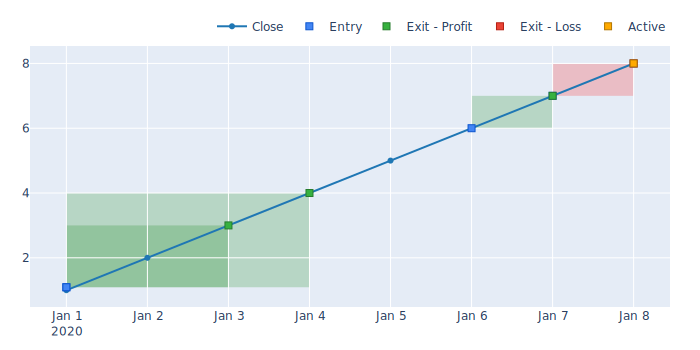

In [179]:
trades['c'].plot().show_svg()

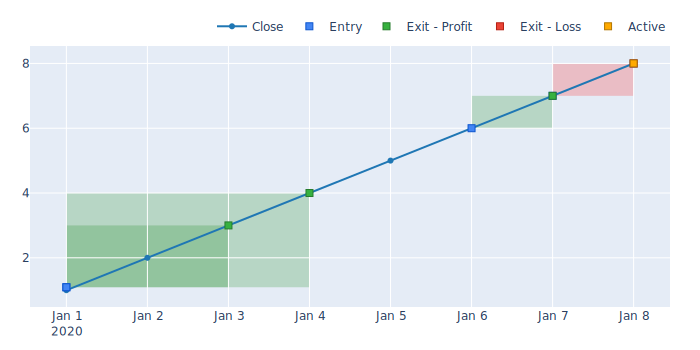

In [180]:
trades.plot(column='c').show_svg()

## Positions

In [53]:
positions = vbt.Positions.from_trades(trades)
positions_grouped = vbt.Positions.from_trades(trades_grouped)
print(positions.values.shape)

(10,)


In [54]:
big_positions = vbt.Positions.from_trades(big_trades)
big_positions_grouped = vbt.Positions.from_trades(big_trades_grouped)
print(big_positions.values.shape)

(500000,)


In [183]:
%timeit vbt.Positions.from_trades(big_trades)

18.9 ms ± 453 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [184]:
print(positions.records)
print(positions.close)

print(positions['a'].records)
print(positions['a'].close)

%timeit big_positions.iloc[0]
%timeit big_positions.iloc[:]

%timeit big_positions_grouped.iloc[0]
%timeit big_positions_grouped.iloc[:]

   id  col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0   0    0   1.1          0     1.090909       0.012         3    3.090909   
1   1    0   1.0          5     6.000000       0.060         6    7.000000   
2   2    0   2.0          7     8.000000       0.160         7    8.000000   
3   3    1   1.1          0     1.090909       0.012         3    3.090909   
4   4    1   1.0          5     6.000000       0.060         6    7.000000   
5   5    1   2.0          7     8.000000       0.160         7    8.000000   
6   6    2   1.1          0     1.090909       0.012         3    3.090909   
7   7    2   1.0          5     6.000000       0.060         6    7.000000   
8   8    2   1.0          6     7.000000       0.070         7    8.000000   
9   9    2   1.0          7     8.000000       0.080         7    8.000000   

   exit_fees    pnl    return  direction  status  
0      0.034  2.154  1.795000          0       1  
1      0.070  0.870  0.145000          

In [185]:
print(positions['a'].coverage())
print(positions.coverage())
%timeit big_positions.coverage()

print(positions.coverage(group_by=group_by))
%timeit big_positions.coverage(group_by=big_group_by)

0.5
a    0.500
b    0.500
c    0.625
d    0.000
Name: coverage, dtype: float64
6.26 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.5000
second    0.3125
Name: coverage, dtype: float64
10.5 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
print(positions['a'].stats())
%timeit big_positions[0].stats(silence_warnings=True)

print(positions.stats(column='a'))
%timeit big_positions.stats(column=0, silence_warnings=True)

print(positions.stats())
%timeit big_positions.stats(silence_warnings=True)

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:447: RuntimeWarning: divide by zero encountered in true_divide
  profit_factor = total_win / np.abs(total_loss)


Start                            2020-01-01 00:00:00
End                              2020-01-08 00:00:00
Period                               8 days 00:00:00
First Position Start             2020-01-01 00:00:00
Last Position End                2020-01-08 00:00:00
Total Records                                      3
Total Long Positions                               3
Total Short Positions                              0
Total Closed Positions                             2
Total Open Positions                               1
Open Position P&L                              -0.16
Win Rate [%]                                   100.0
Max Win Streak                                     2
Max Loss Streak                                    0
Best Position [%]                              179.5
Worst Position [%]                              14.5
Avg Winning Position [%]                        97.0
Avg Losing Position [%]                          NaN
Avg Winning Position Duration        2 days 00

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:408: RuntimeWarning: invalid value encountered in true_divide
  return self.wrapper.wrap_reduced(win_count / total_count, group_by=group_by, **wrap_kwargs)
/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:447: RuntimeWarning: invalid value encountered in true_divide
  profit_factor = total_win / np.abs(total_loss)


153 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Start                            2020-01-01 00:00:00
End                              2020-01-08 00:00:00
Period                               8 days 00:00:00
First Position Start             2020-01-01 00:00:00
Last Position End                2020-01-08 00:00:00
Total Records                                    2.5
Total Long Positions                             1.5
Total Short Positions                            1.0
Total Closed Positions                          1.75
Total Open Positions                            0.75
Open Position P&L                               -0.1
Win Rate [%]                               55.555556
Max Win Streak                              1.333333
Max Loss Streak                                  1.0
Best Position [%]                         113.388889
Worst Position [%]                        -63.031746
Avg Winning Position [%]                        97.0
Avg Losing Position [%]        